<a id='home'></a>
### purpose

Calculate genetic offset using risk of non-adaptedness (RONA, <i>sensu</i> [Rellstab et al. 2016](https://doi.org/10.1111/mec.13889)) using loci from snp sets (created in ../04_create_datasets-wza_baypass_random.ipynb) that have significant linear models.

Further explore RONA scores by varying which climates to include:

    1. using paired t tests, as in Rellstab et al. 2016
    2. climate variables used in British Columbia's climate-based seed transfer
    3. climate variables explaining significant variation in common garden trials


### outline

[1. get the snps](#snps)
- get the loci that were assigned to testing set loci groups in `../04_create_datasets-wza_baypass_random.ipynb#outliers`

[2. Estimate linear models](#estimate)
- get slope, intercept and p-value for each of these group loci for each of the envs

[3. Retrieve loci with significant linear models](#retrieve)
- of the loci in the loci sets, determine which had significant linear relationships between environment and ALT allele frequencies

[4. Load common garden climate data (all possible "$EF_{future}$")](#load)
- instead of future data, load data of the common garden

[5. Calculate the RONA](#rona)

- for each env for each pop for each garden, calculate RONA for each group of loci (for those loci with sig linear models)
- first calculate the typical summation element (google "parts of summation notation") of RONA in parallel
- then calculate mean after gathering parallelized info

[6. Calculate correlation with genetic offset](#correlation)
- calculate correlation between RONA and phenotypes in the common garden
- plot scatter plots of relationships

[7. Determine environmental factors ($EF_{future}$) to use to validate RONA](#factors)
- In Rellstab et al. 2016, they determined the environmental factors to use to calculate rona by using paired $t$
  tests between current and future climate, and keeping the top three.
    - Here, I do this but use the common garden data for each 'future' climate.
    - I keep the top 5 environments based on pvalue ranking for each species/garden combo
    - the hypothesis for this test isn't really ideal, though, for my data, since I'd be assigning one value to all populations (one value representing the common garden climate). For this reason, I use other means by which to choose climate variables for comparision.
- I will also see how the choice of environments affects RONA agreement with garden data - see ../08_climate_and_geographic_distance_vs_phenotypes:

    1. climate vars from paired t-tests (as in Rellstab et al. 2016)
    2. those climate vars used by British Columbia's climate-based seed transfer
    3. those climate vars shown to explain significant variation in the common garden trials of these species The climate variables for the transfer function used to best predict lodgepole pine height was MAT (>64% var exp) and ln(AHM) (> 6%).

            Wang T, Hanann A, Yanchuk A, O’Neill GA, Aitken SN. 2006. Use of response functions in selecting lodgepole pine populations for future climates. Global Change Biol 12:2404–2416.

        For Douglas-fir, it is MAT, SHM, and TD – though MAT alone explained the vast majority of variation (77-92% depending on phenotype)s.

            Chakraborty D, Wang T, Andre K, Konnert M, Lexer MJ, Matulla C, Schueler S. 2015. Selecting Populations for Non-Analogous Climate Conditions Using Universal Response Functions: The Case of Douglas-Fir in Central Europe. Plos One 10:e0136357.

    4. WZA vars - the subset of climate vars that are being used for WZA

[8. Create some plots](#plots)
- create boxplots of RONA for each garden for each pheno for each locus source

[9. explore](#explore)

### conclusions / initial thoughts <UPDATE!>
- for jack pine, most of the strong correlations between RONA and common garden performance were among the envs that have a strong longitudinal cline, and therefore are correlated with geographic distance to the common garden. Basically, for the cases it seems to do ok, it might be doing ok by accident.
- for the combined doug-fir set (both varieties) there is a strong correlation between RONA and common garden data, but each genetic group seems to have its own slope (

### notes
- for wza envs, I excluded LAT since we didn't do GEA to LAT

In [1]:
from pythonimports import *
from IPython.display import Image
from scipy.stats import linregress
from scipy.stats import ttest_rel
import seaborn as sns
from myfigs import save_pdf
from myfigs import histo_box
from matplotlib.lines import Line2D

sns.set(rc={'figure.figsize':(8,5)})

ronadir = makedir('/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/rona')

<a id='snps'></a>
# 1. get snp sets
- get the loci that were assigned to testing sets in `../04_create_datasets-wza_baypass_random.ipynb#outliers`

[top](#home)

In [2]:
t1 = dt.now()  # notebook timer

lview,dview = get_client()

latest_commit()
sinfo(html=True)

56 56
##################################################################
Current commit of pythonimports:
commit 9f2b6d7984dd7a121d365ff406e02c14cafd5560  
Author: Brandon Lind <brandon.lind@ubc.ca>  
Date:   Fri Apr 22 13:34:17 2022 -0600
Today:	April 28, 2022 - 11:01:43
python version: 3.8.5
##################################################################



In [3]:
# get files that have loci IDs among sets created in ../04_create_datasets-wza_baypass_random.ipynb#outliers
training_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files'
files = fs(training_dir, 'full', endswith='.txt', exclude='envdata')
len(files)

27

In [4]:
# get a list of methods and names for loci sets
loci_setnames = []
methods = []
for f in files:
    spp,method,setname,kfold = op.basename(f).rstrip('.txt').split('-')
    print(spp, method, setname, kfold)
    loci_setnames.append(setname)
    methods.append(method)

loci_setnames = sorted(uni(loci_setnames), reverse=True)
methods = suni(methods)
loci_setnames

combined baypass pseudo_random_loci full
combined baypass random full
combined baypass real full
combined wza pseudo_random_loci full
combined wza random full
combined wza real full
fdc baypass pseudo_random_loci full
fdc baypass random full
fdc baypass real full
fdc wza pseudo_random_loci full
fdc wza random full
fdc wza real full
fdi baypass pseudo_random_loci full
fdi baypass random full
fdi baypass real full
fdi wza pseudo_random_loci full
fdi wza random full
fdi wza real full
jp baypass pseudo_random_loci full
jp baypass random full
jp baypass real full
jp wza pseudo_random_loci full
jp wza random full
jp wza real full
wl wza pseudo_random_loci full
wl wza random full
wl wza real full


['real', 'random', 'pseudo_random_loci']

In [5]:
methods

['baypass', 'wza']

In [6]:
# get the loci that were assigned to testing sets in ../04_create_datasets-wza_baypass_random.ipynb#outliers
    # ie union of random/baypass/wza/psuedo_random sets
# (I want to reduce the time to calculate linear models, only need to do these loci)
spploci = defaultdict(list)
grouploci = wrap_defaultdict(None, 3)
for f in files:
    spp,method,setname,kfold = op.basename(f).rstrip('.txt').split('-')
    
    df = pd.read_table(f, index_col='index', nrows=1)
    # this next line from a previous run where I had accidentally wrote txt with multiple index 
        # (can prob deprecate, but no harm if I leave it)
    loci = [locus for locus in df.columns if 'Unnamed' not in locus and 'level' not in locus]
    
    print(spp, method, setname, len(loci))
    grouploci[spp][method][setname] = loci
    spploci[spp].extend(loci)
    
print('\n')

for spp,loci in spploci.items():
    spploci[spp] = uni(loci)
    print(spp, len(spploci[spp]))

combined baypass pseudo_random_loci 25219
combined baypass random 25219
combined baypass real 25219
combined wza pseudo_random_loci 14760
combined wza random 14760
combined wza real 14760
fdc baypass pseudo_random_loci 17516
fdc baypass random 17516
fdc baypass real 17516
fdc wza pseudo_random_loci 4886
fdc wza random 4886
fdc wza real 4886
fdi baypass pseudo_random_loci 12398
fdi baypass random 12398
fdi baypass real 12398
fdi wza pseudo_random_loci 11434
fdi wza random 11434
fdi wza real 11434
jp baypass pseudo_random_loci 22635
jp baypass random 22635
jp baypass real 22635
jp wza pseudo_random_loci 4788
jp wza random 4788
jp wza real 4788
wl wza pseudo_random_loci 8496
wl wza random 8496
wl wza real 8496


combined 114396
fdc 64714
fdi 68488
jp 76320
wl 25378


<a id='estimate'></a>
# 2. estimate linear models

[top](#home)

In [7]:
def frequenize(df, spp=None):
    """Convert allele freq percent to float, reduce loci to those assigned to `spp` in `spploci[spp]`."""
    import pandas 

    locuscol = 'unstitched_locus' if 'unstitched_locus' in df.columns.tolist() else 'locus'
    
    freqcols = [col for col in df.columns if 'FREQ' in col]
    
    df.index = df[locuscol].tolist()
    
    df = df[
        df.index.isin(spploci[spp])
    ]
    
    df = df[freqcols].apply(lambda percent: percent.str.rstrip("%").astype(float)/100, axis=1)
    df.columns = [col.rstrip(".FREQ") for col in df.columns]  # convert to pop names

    return df
dview['spploci'] = spploci


def read_envdata(envfile, pops):
    """Read in climate data, order populations (rows) by `pops` and columns by `envs`."""
    import pandas as pd
    
    envs = ['Elevation', 'AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP', 'MAP', 'MAT', 'MCMT',
            'MSP', 'MWMT', 'NFFD', 'PAS', 'SHM', 'TD', 'bFFP', 'eFFP']
    assert len(envs) == 20
    
    envdata = pd.read_table(envfile)
    envdata.index = envdata['our_id'].tolist()
    envdata = envdata[envs].loc[pops]
    
    return envdata
dview['read_envdata'] = read_envdata


def train(freqs, envfile=None):
    """Calculate linear regression slope, intercept, and p-val for each locus for each environmental variable.
    
    Environmental variables are climate normals from 1961-1991 from ClimateNA for each population.
    
    Parameters
    ----------
    freqs - output from `frequenize`
    envfile - path to climate data
    """
    from scipy.stats import linregress
    from tqdm import tqdm as pbar
    from collections import defaultdict
    
    envdata = read_envdata(envfile, freqs.columns.tolist())
    
    results = wrap_defaultdict(tuple, 2)
    for env in envdata.columns:
        for locus in pbar(freqs.index, desc=env):
            goodpops = envdata.index[freqs.loc[locus].notnull()]  # pops without missing data
            slope,intercept,rval,pval,stderr = linregress(envdata[env].loc[goodpops],
                                                          freqs[goodpops].loc[locus])
            results[env][locus] = slope,intercept,pval

    return results
dview['wrap_defaultdict'] = wrap_defaultdict

In [8]:
snpfiles = {
    'jp' : '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt',
    'fdi' : '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt',
    'fdc' : '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt',
    'combined' : '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/combined_varieties/03_maf-p05_RD-recalculated_both/DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt'
}

In [9]:
envfiles = {
    'jp' : '/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt',
    'fdi' : '/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_raw_env-19variables_change-p6.txt',
    'fdc' : '/data/projects/pool_seq/environemental_data/change_p6/df_coastal-naturalpops_raw_env-19variables_change-p6.txt',
    'combined' : '/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt'
}

In [10]:
# test
spp = 'jp'
freqs = frequenize(pd.read_table(snpfiles[spp],
                                 nrows=100),
                   spp)
assert all(freqs.index.isin(spploci[spp]))

envdict = train(freqs, envfiles[spp])

eFFP: 100%|██████████| 4/4 [00:00<00:00, 313.05it/s]


In [11]:
for env,locusdict in envdict.items():
    print(env, len(locusdict))

Elevation 4
AHM 4
CMD 4
DD5 4
DD_0 4
EMT 4
EXT 4
Eref 4
FFP 4
MAP 4
MAT 4
MCMT 4
MSP 4
MWMT 4
NFFD 4
PAS 4
SHM 4
TD 4
bFFP 4
eFFP 4


In [12]:
# calculate linear models in parallel for each species
results = wrap_defaultdict(dict, 2)
for spp,file in snpfiles.items():
    
    # the functions and arguments to be applied in parallel
    fundict = create_fundict(frequenize,
                             kwargs={'spp' : spp})
    fundict.update(
        create_fundict(
            train,
            kwargs={'envfile': envfiles[spp]}
        )
    )
    
    jobs = parallel_read(
        file, lview=lview, dview=dview, verbose=False, maintain_dataframe=False, functions=fundict
    )
    
    # gather results
    for envdict in jobs:
        for env,locusdict in envdict.items():
            results[spp][env].update(locusdict)
            
    # check assumptions
    for env,locusdict in results[spp].items():
        assert len(locusdict) == len(spploci[spp])
        assert len(set(locusdict.keys()).intersection(spploci[spp])) == len(spploci[spp])
    
    # sanity check
    dview['spp'] = None
    dview['envfile'] = None
    sleeping(7)

# clear memory from engines
client = Client()
_ = client.clear(client.ids)

# save
pkl = op.join(ronadir, 'linear_models.pkl')
pkldump(results, pkl)


Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [01:43<00:00,  1.85s/it] 


Function `parallel_read` completed after : 0-00:01:55


sleeping: 100%|███████████████| 7/7 [00:07<00:00,  1.00s/it]



Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [01:42<00:00,  1.84s/it] 


Function `parallel_read` completed after : 0-00:01:57


sleeping: 100%|███████████████| 7/7 [00:07<00:00,  1.00s/it]



Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [01:36<00:00,  1.73s/it] 


Function `parallel_read` completed after : 0-00:01:51


sleeping: 100%|███████████████| 7/7 [00:07<00:00,  1.00s/it]



Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [03:26<00:00,  3.68s/it]  


Function `parallel_read` completed after : 0-00:03:43


sleeping: 100%|███████████████| 7/7 [00:07<00:00,  1.00s/it]


In [13]:
# time up until this point
formatclock(dt.now() - t1, exact=True)

'0-00:11:08'

In [14]:
dview['spploci'] = spploci
sleeping(20)

sleeping: 100%|███████████████| 20/20 [00:20<00:00,  1.00s/it]


<a id='retrieve'></a>
# 3. retrieve loci with significant linear models

[top](#home)

In [15]:
# pkl = op.join(ronadir, 'linear_models.pkl')
# results = pklload(pkl)

In [16]:
# assert no NaNs (shouldn't be since I accounted for missing data)
for spp,envdict in results.items():
    for env,locusdict in pbar(envdict.items(), desc=spp):
        for locus,(slope,intercept,pval) in locusdict.items():
            assert all(
                [
                    isinstance(slope, float),
                    isinstance(pval, float),
                    isinstance(intercept, float)
                ]
            )

combined: 100%|███████████████| 20/20 [00:01<00:00, 13.85it/s]


In [17]:
# determine which of the loci had pvals <= 0.05
keep = wrap_defaultdict(list, 2)
for spp,envdict in results.items():
    for env,locusdict in pbar(envdict.items(), desc=spp):
        for locus,(slope,intercept,pval) in locusdict.items():
            if pval <= 0.05:
                keep[spp][env].append(locus)

for spp,envdict in keep.items():
    for env,loci in envdict.items():
        print(spp, env, len(loci), len(results[spp][env].keys()))

combined: 100%|███████████████| 20/20 [00:00<00:00, 26.55it/s]


jp Elevation 12649 76320
jp AHM 12603 76320
jp CMD 11497 76320
jp DD5 21853 76320
jp DD_0 26857 76320
jp EMT 26363 76320
jp EXT 8897 76320
jp Eref 21814 76320
jp FFP 22519 76320
jp MAP 23788 76320
jp MAT 25936 76320
jp MCMT 27101 76320
jp MSP 21893 76320
jp MWMT 20333 76320
jp NFFD 15064 76320
jp PAS 13774 76320
jp SHM 14492 76320
jp TD 25830 76320
jp bFFP 16493 76320
jp eFFP 25730 76320
fdi Elevation 20605 68488
fdi AHM 8679 68488
fdi CMD 4488 68488
fdi DD5 10366 68488
fdi DD_0 15954 68488
fdi EMT 20270 68488
fdi EXT 15264 68488
fdi Eref 16155 68488
fdi FFP 6325 68488
fdi MAP 14721 68488
fdi MAT 12617 68488
fdi MCMT 21266 68488
fdi MSP 4918 68488
fdi MWMT 13606 68488
fdi NFFD 8992 68488
fdi PAS 6586 68488
fdi SHM 3649 68488
fdi TD 21058 68488
fdi bFFP 4671 68488
fdi eFFP 8886 68488
fdc Elevation 14648 64714
fdc AHM 13585 64714
fdc CMD 23649 64714
fdc DD5 20219 64714
fdc DD_0 13123 64714
fdc EMT 7074 64714
fdc EXT 22455 64714
fdc Eref 25142 64714
fdc FFP 3860 64714
fdc MAP 14087 64714


In [18]:
results[spp][env][locus]

(-0.007393055553088478, 2.7120764846586267, 1.6664544668422561e-10)

<a id='load'></a>
# 4. load common garden climate data ($EF_{future}$)

- as in `../07_fit_gradient_forest_models_to_common_garden_data`
- this is needed for $EF_{future}$ (see RONA eqn [below](#rona))
    - in their equation they were projecting to a future climate, I'm projecting to the recent climate of a common garden
    
[top](#home)

In [19]:
# doug-fir vancouver data
vanfile = '/data/projects/pool_seq/environemental_data/vancouver_data/vancouver_climate-2018-2019_USING.txt'
vanclim = pd.read_table(vanfile, index_col=0)
vanclim = vanclim[vanclim.index =='two_year_avg']
vanclim.index = ['vancouver']
vanclim.columns.values[:2] = ['Latitude', 'Longitude']
vanclim

Latitude  Longitude  Elevation    AHM    CMD     DD5  DD_0   EMT  \
vancouver    49.257    -123.25       81.0  18.05  301.0  2487.5  86.5 -13.5   

            EXT   Eref    FFP     MAP   MAT  MCMT    MSP   MWMT   NFFD   PAS  \
vancouver  35.0  648.0  262.0  1194.0  11.2   5.4  259.0  19.65  320.5  36.0   

             SHM     TD  bFFP   eFFP  
vancouver  76.65  14.25  60.0  322.0

In [20]:
# jack pine ste christine and fontbrune data
jpdir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'
jpclim = pd.read_table(
    op.join(jpdir,
            'jack_pine_common_gardens_average_climate_1966-2018.txt'),
    index_col=0
).loc[['christine', 'fontbrune']]

jpclim

Latitude  Longitude  Elevation        AHM         CMD  \
christine  46.818749 -71.887803        156  12.179245   77.132075   
fontbrune  46.959018 -75.698440        247  13.962264  135.018868   

                   DD5         DD_0   EMT   EXT        Eref         FFP  \
christine  1739.150943  1281.716981 -38.9  43.6  621.962264  127.056604   
fontbrune  1624.962264  1418.849057 -41.1  42.6  646.849057  116.056604   

                   MAP       MAT       MCMT         MSP       MWMT  \
christine  1162.169811  3.998113 -13.845283  561.150943  18.962264   
fontbrune   953.754717  3.237736 -15.224528  475.490566  18.154717   

                 NFFD         PAS        SHM         TD        bFFP  \
christine  157.113208  358.075472  34.554717  32.811321  141.094340   
fontbrune  144.320755  298.849057  38.800000  33.377358  147.358491   

                 eFFP  
christine  268.169811  
fontbrune  263.471698

In [21]:
# combine
cgdata = pd.concat([jpclim, vanclim])
cgdata.columns = [col.replace('Latitude', 'LAT').replace('Longitude', 'LONG') for col in cgdata.columns]
cgdata

LAT        LONG  Elevation        AHM         CMD  \
christine  46.818749  -71.887803      156.0  12.179245   77.132075   
fontbrune  46.959018  -75.698440      247.0  13.962264  135.018868   
vancouver  49.257000 -123.250000       81.0  18.050000  301.000000   

                   DD5         DD_0   EMT   EXT        Eref         FFP  \
christine  1739.150943  1281.716981 -38.9  43.6  621.962264  127.056604   
fontbrune  1624.962264  1418.849057 -41.1  42.6  646.849057  116.056604   
vancouver  2487.500000    86.500000 -13.5  35.0  648.000000  262.000000   

                   MAP        MAT       MCMT         MSP       MWMT  \
christine  1162.169811   3.998113 -13.845283  561.150943  18.962264   
fontbrune   953.754717   3.237736 -15.224528  475.490566  18.154717   
vancouver  1194.000000  11.200000   5.400000  259.000000  19.650000   

                 NFFD         PAS        SHM         TD        bFFP  \
christine  157.113208  358.075472  34.554717  32.811321  141.094340   
fontbrune  144.320755  298.849057  38.800000  33.377358  147.358491   
vancouver  320.500000   36.000000  76.650000  14.250000   60.000000   

                 eFFP  
christine  268.169811  
fontbrune  263.471698  
vancouver  322.000000

<a id='rona'></a>
# 5. calculate the RONA

- for each env for each pop, calculate RONA for each group of loci (for those loci with sig linear models)
- first calculate the typical summation element (google "parts of summation notation") of RONA in parallel
- then calculate RONA after gathering parallelized info


[top](#home)

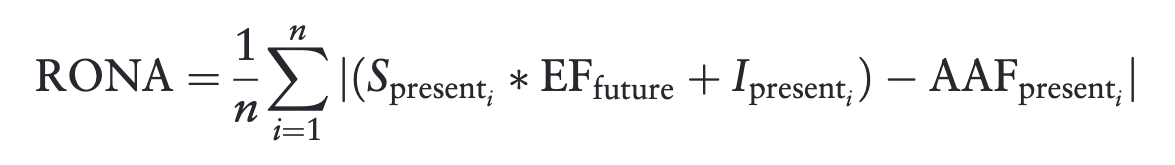

In [22]:
# from Rellstab et al. 2016 
# - this should really be RONA_p_e (RONA is calculated for a single pop for a single environmental variable)
Image(filename='RONA.png') 

In [23]:
# to save time, calculate the abs element within the summation in parallel,
    # then sum and average later on to avoid redundant calculations

# which spp go with which gardens?
cgdict = {
    'jp' : ['christine', 'fontbrune'],
    'fdi' : ['vancouver'],
    'fdc' : ['vancouver'],
    'combined' : ['vancouver']
}
dview['cgdict'] = cgdict

def calc_rona_elements(spp, garden, env, pop, aaf_present):
    """Calculate and return the abs element for each of n loci in `aaf_present.index`."""
    ef_fut = cgdata[env].loc[garden]
    
    rona_elements = {}
    for locus_i in aaf_present.index:
        s_present, i_present, pval = results[spp][env][locus_i]
        # nans can be appended if locus has missing data for that pop, account for this when summing/avging
        rona_elements[locus_i] = abs(
            (s_present * ef_fut) + i_present - aaf_present[pop].loc[locus_i]
        )
    
    return rona_elements
dview['calc_rona_elements'] = calc_rona_elements
dview['cgdata'] = cgdata
dview['results'] = results

def get_rona_elements(freqs, spp=None):
    """Calculate the typical summation element of RONA for loci with siginificant linear models."""
    from collections import defaultdict
    
    elements = wrap_defaultdict(None, 4)
    for env,loci in keep[spp].items():
        interloci = set(loci).intersection(freqs.index)
        for garden in cgdict[spp]:
            for pop in freqs.columns:
                elements[spp][env][garden][pop] = calc_rona_elements(spp,
                                                                     garden,
                                                                     env,
                                                                     pop,
                                                                     freqs.loc[interloci])
    return elements
dview['keep'] = dict(keep)
dview['wrap_defaultdict'] = wrap_defaultdict  # re-add since I'm clearing engines

In [24]:
# test function
spp = 'fdc'

freqs = frequenize(
    pd.read_table(snpfiles[spp], nrows=1000),
    spp
)

output = get_rona_elements(freqs, spp)

output['fdc']['AHM']['vancouver']['DF_p28']  # note nan from locus/pop combo with missing data

{'jcf7190000000022-98544': 0.22892880431842288, 'jcf7190000000008-430119': nan}

In [25]:
# wait for data to load to engines
sleeping(60)

sleeping: 100%|███████████████| 60/60 [01:00<00:00,  1.00s/it]


In [26]:
# calculate rona elements in parallel
rona_elements = wrap_defaultdict(dict, 4)
for spp,file in snpfiles.items():
    
    # organize functions to call in parallel
    functions = create_fundict(frequenize, kwargs={'spp' : spp})
    functions.update(
        create_fundict(get_rona_elements, kwargs={'spp' : spp})
    )
    
    # calculate rona elements in parallel
    jobs = parallel_read(file,
                         lview=lview,
                         dview=dview,
                         verbose=False,
                         functions=functions,
                         maintain_dataframe=False)
    
    # gather elements
    for j in jobs:
        for spp,envdict in j.items():
            for env,gardendict in envdict.items():
                for garden,popdict in gardendict.items():
                    for pop,elementdict in popdict.items():
                        # `elementdict` is returned from `calc_rona_elements` - key=locus, val=summation_element
                        rona_elements[spp][env][garden][pop].update(elementdict)

# clear memory from engines
client = Client()
_ = client.clear(client.ids)


Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [00:40<00:00,  1.39it/s]


Function `parallel_read` completed after : 0-00:00:53

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [00:29<00:00,  1.90it/s]


Function `parallel_read` completed after : 0-00:00:44

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [00:32<00:00,  1.70it/s]


Function `parallel_read` completed after : 0-00:00:49

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [01:59<00:00,  2.13s/it] 


Function `parallel_read` completed after : 0-00:02:16


In [27]:
# clear memory from engines
client = Client()
_ = client.clear(client.ids)

In [28]:
# Calculate the real rona by summing and averaging - separate loci by group

rona = wrap_defaultdict(None, 6)  # one RONA per pop per climate
rona_loci_counts = wrap_defaultdict(None, 6)
all_counts = wrap_defaultdict(list, 5)
for spp,envdict in rona_elements.items():
    for env,gardendict in pbar(envdict.items(), desc=spp):
        for garden,popdict in gardendict.items():
            for pop,elementdict in popdict.items():
                # make sure I got what I was expecting to get - number of loci with sig linear models
                assert len(elementdict) == len(keep[spp][env])

                # for each group of loci, calc RONA by according to equation above by 
                    # averaging rona_elements while accounting for missing data
                for method,locus_setdict in grouploci[spp].items():
                    for setname,setloci in locus_setdict.items():
                        # get all of the typical summation elements for loci within `setname` that have sig models
                        interloci = set(setloci).intersection(elementdict.keys())
                        elements = [elementdict[locus] for locus in interloci]
                        if sum(el==el for el in elements) > 0:
                            # if at least one instance of non-np.nan data:
                            _mean = np.nanmean(elements)  # np.nanmean accounts for missing data
                        else:
                            # avoid RuntimeWarning: Mean of empty slice
                            # this happened when a pop had missing data at all of the few number of loci given (eg 2)
                                # and each `el` in `elements` was therefore `np.nan`
                            _mean = np.nan
                        rona[spp][env][garden][pop][method][setname] = _mean
                        rona_loci_counts[spp][env][garden][pop][method][setname] = len(interloci)
                        all_counts[spp][garden][method][setname][env].append(interloci)

combined: 100%|███████████████| 20/20 [05:06<00:00, 15.31s/it]


<a id='efdict'></a>

### explore data behind RONA calculations

- it will be necessary to know the number of loci with sig linear models behind the RONA calculations, since the actual number of loci used will differ from the setnumber (ie the 'baypass-real' group won't be using all 'baypass-real' loci; same with '-random'/'-pseudo_random', and 'wza')
- I eventually combine this dataframe `_x` with another (`num_loci_counts`) calculated using subset of envs [here](#ef_figs) into `all_num_loci_counts` before saving the data together as .txt

In [29]:
_x = pd.DataFrame(
    columns=['spp', 'garden', 'method', 'setname', 'ef_setname',
             'num_loci', 'mean_count', 'min_count', 'max_count']
)
for spp,gardendict in all_counts.items():
    for garden,methoddict in pbar(gardendict.items(), desc=spp):
        for method,setdict in methoddict.items():
            for setname,envdict in setdict.items():
                num_loci = luni(
                    [locus for env,pops in envdict.items() for poploci in pops for locus in poploci]
                )
                loci_counts = [
                    uni([len(poploci) for poploci in envdict[env]])[0] for env in envdict
                ]
                mean_count = np.mean(loci_counts)
                _x.loc[nrow(_x)] = (spp, garden, method, setname, 'all',
                                    num_loci, mean_count, min(loci_counts), max(loci_counts))

combined: 100%|███████████████| 1/1 [00:09<00:00,  9.60s/it]


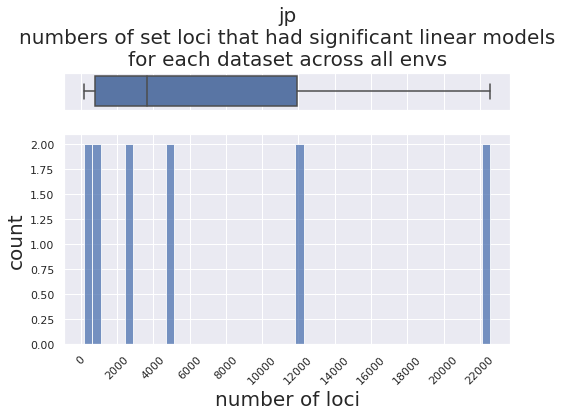

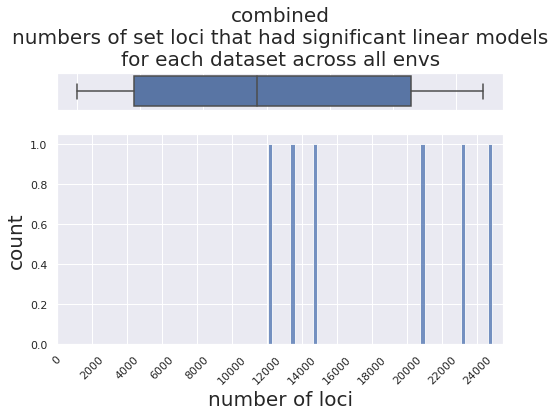

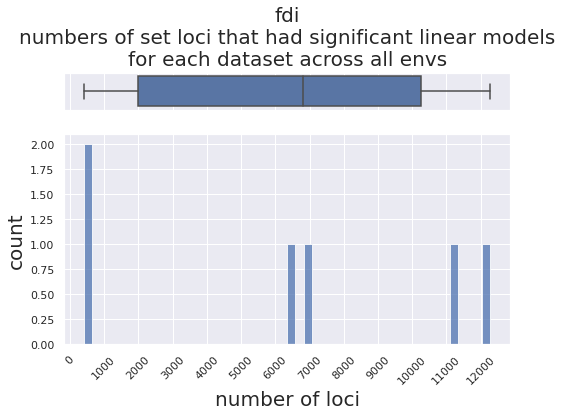

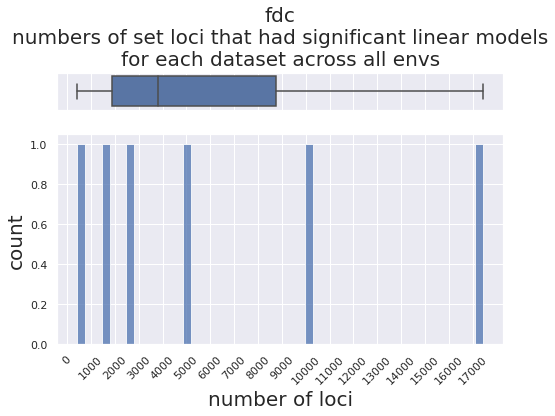

In [30]:
# distribution of set loci with significant linear models used in the RONA calculations
# (there are 6 datasets = 2 methods x 3 setnames)

# figure out xticks
for spp in uni(_x['spp']):
    sppdf = _x[_x['spp']==spp]
    
    digits = len(str(max(sppdf['num_loci']))) - 2 
    xtick = round(max(sppdf['num_loci'])/13, -digits)
    if xtick < 10:
        xtick = 10

    histo_box(sppdf['num_loci'].tolist(),
              xlab=f'number of loci',
              ylab='count',
              title='\n'.join([spp,
                               'numbers of set loci that had significant linear models',
                               'for each dataset across all envs']),
              xticks_by=xtick,
              rotation=45,
              histbins=50
             )
    plt.show()

#### to see how counts differ when considering specific groups of environmental factors, go [here](#ef_figs)

### check assumptions and save 

In [31]:
# the number of significant linear models should be fewer than the number of loci in the set
for (spp,env,garden,pop,method,setname),locicount in unwrap_dictionary(rona_loci_counts):
    if spp == 'combined':
        summ = len(grouploci['fdi'][method][setname]) + len(grouploci['fdc'][method][setname])
        assert summ > locicount
    else:
        assert len(grouploci[spp][method][setname]) > locicount

In [32]:
rona[spp][env][garden][pop][method]

defaultdict(None,
            {'pseudo_random_loci': 0.0899549164346963,
             'random': 0.09299294392868997,
             'real': 0.15045984150610556})

In [33]:
# save
pkldump(rona, op.join(ronadir, 'rona.pkl'))

In [34]:
# save
pkldump(rona_elements, op.join(ronadir, 'rona_elements.pkl'))

In [35]:
pkldump(rona_loci_counts, op.join(ronadir, 'rona_loci_counts.pkl'))

In [36]:
# save
pkldump(keep, op.join(ronadir, 'keep.pkl'))

In [37]:
# save
pkldump(rona_loci_counts, op.join(ronadir, 'rona_loci_counts.pkl'))

In [38]:
# time up until this point
formatclock(dt.now() - t1, exact=True)

'0-00:34:11'

<a id='correlation'></a>
# 6. calculate correlation between each RONA_env and common garden data

[top](#home)

### read in population data 

In [39]:
# reconnect to engines
lview,dview = get_client()

56 56


In [40]:
jpphenodir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'
dfphenodir = '/data/projects/pool_seq/phenotypic_data/doug-fir'

In [41]:
# jack pine
envdata = {}
envdata['jp'] = pd.read_table(envfiles['jp'])
envdata['jp'].index = envdata['jp']['our_id'].tolist()
envdata['jp'].head()

id1  id2   our_id      LAT      LONG  Elevation   AHM  CMD   DD5  \
JP_p98   9150251   38   JP_p98  54.3333 -106.6333        537  21.2  181  1273   
JP_p73      3273   22   JP_p73  44.4200  -84.6800        359  22.0  241  1956   
JP_p97   8060006   37   JP_p97  56.1167 -116.9167        636  23.5  242  1188   
JP_p60      3260   17   JP_p60  46.7200  -84.3900        203  16.5  135  1557   
JP_p100  9040116   40  JP_p100  55.7667  -97.8167        205  13.3  130  1003   

         DD_0   EMT   EXT  Eref  FFP  MAP  MAT  MCMT  MSP  MWMT  NFFD  PAS  \
JP_p98   2217 -46.0  34.7   534  103  461 -0.2 -20.1  305  16.6   149  129   
JP_p73    835 -34.1  36.6   745  131  732  6.1  -8.0  395  19.8   163  140   
JP_p97   2009 -44.3  34.8   556   90  432  0.2 -19.8  272  15.4   138  133   
JP_p60   1116 -36.8  34.3   599  123  848  4.0 -10.7  397  17.6   156  265   
JP_p100  2956 -49.7  35.2   448   82  506 -3.3 -24.9  315  15.7   106  191   

          SHM    TD  bFFP  eFFP group_color  
JP_p98   54.4  36.7   148   251       green  
JP_p73   50.0  27.8   141   271        blue  
JP_p97   56.5  35.1   151   241       green  
JP_p60   44.2  28.3   147   271        blue  
JP_p100  49.9  40.6   163   245       green

In [42]:
# jack pine phenotype

# get the common garden files for jack pine
jpfiles = fs(jpphenodir, 'cg-data_provpops')

phenos = ['Mortality_2018', 'Mean_Height_2018', 'Mean_DBH2018']

jpdata = {}
for f in jpfiles:
    garden = f.split("_")[-1].rstrip('.txt')
    if garden == 'petawawa':
        continue
    elif garden == 'st-christine':
        garden = 'christine'  # match name in `cgdata.index`
    jpdata[garden] = pd.read_table(f)
    jpdata[garden].index = jpdata[garden]['our_id'].tolist()
    jpdata[garden] = jpdata[garden][phenos]
    print(garden, nrow(jpdata[garden]))

jpdata[garden].head()

fontbrune 27
christine 28


Mortality_2018  Mean_Height_2018  Mean_DBH2018
JP_p4             70.0           1799.09        228.00
JP_p6             64.0           1856.67        239.60
JP_p8             58.0           1988.95        259.63
JP_p14            72.0           1636.67        211.83
JP_p20            88.0           1578.33        218.50

In [43]:
# doug-fir pop data

# map prov ID to our ID to translate pop names in phenotype data below
envdata['combined'] = pd.read_table(envfiles['combined'])
envdata['combined'].index = envdata['combined']['our_id'].tolist()
provdict = dict(zip(envdata['combined']['prov'], envdata['combined']['our_id']))
print(provdict)

{1: 'DF_p1', 2: 'DF_p2', 3: 'DF_p3', 4: 'DF_p4', 5: 'DF_p5', 6: 'DF_p6', 7: 'DF_p7', 8: 'DF_p8', 9: 'DF_p9', 10: 'DF_p10', 11: 'DF_p11', 12: 'DF_p12', 13: 'DF_p13', 14: 'DF_p14', 15: 'DF_p15', 16: 'DF_p16', 17: 'DF_p17', 18: 'DF_p18', 19: 'DF_p19', 20: 'DF_p20', 23: 'DF_p23', 24: 'DF_p24', 25: 'DF_p25', 26: 'DF_p26', 27: 'DF_p27', 28: 'DF_p28', 29: 'DF_p29', 30: 'DF_p30', 31: 'DF_p31', 32: 'DF_p32', 33: 'DF_p33', 34: 'DF_p34', 35: 'DF_p35', 36: 'DF_p36', 37: 'DF_p37', 38: 'DF_p38', 39: 'DF_p39', 40: 'DF_p40', 41: 'DF_p41', 42: 'DF_p42', 43: 'DF_p43', 44: 'DF_p44', 45: 'DF_p45', 46: 'DF_p46', 47: 'DF_p47', 48: 'DF_p48', 49: 'DF_p49', 50: 'DF_p50', 51: 'DF_p51', 52: 'DF_p52', 53: 'DF_p53', 54: 'DF_p54', 55: 'DF_p55', 56: 'DF_p56', 57: 'DF_p57', 58: 'DF_p58', 59: 'DF_p59', 60: 'DF_p60', 61: 'DF_p61', 62: 'DF_p62', 72: 'DF_p72', 73: 'DF_p73', 74: 'DF_p74', 75: 'DF_p75', 76: 'DF_p76', 77: 'DF_p77', 78: 'DF_p78', 79: 'DF_p79', 80: 'DF_p80', 81: 'DF_p81', 82: 'DF_p82', 83: 'DF_p83', 84: 'DF_p

In [44]:
# coastal
envdata['fdc'] = envdata['combined'][envdata['combined']['Variety']=='FDC'].copy()
nrow(envdata['fdc'])

38

In [45]:
# interior
envdata['fdi'] = envdata['combined'][envdata['combined']['Variety']=='FDI'].copy()
nrow(envdata['fdi'])

35

In [46]:
assert nrow(envdata['fdi']) + nrow(envdata['fdc']) == nrow(envdata['combined'])

In [47]:
# get common garden files for doug-fir
# read in two phenofiles, combine - skip this after updating phenotypes in Nov 2021

# drought = pd.read_table('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Drought_Blups_May_01_2021_Brandon_prov.txt')
# drought = drought[drought['Prov'].isin(keys(provdict))]
# drought.index = drought['Prov'].map(provdict)
# print(sum(envdata['combined'].index.isin(drought.index)))

# _phenodata = pd.read_table('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Totem_Blups_April_26_2021_Brandon-BLUPs_prov.txt')
_phenodata = pd.read_excel('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Totem_Blups_Nov_17_2021_Brandon.xlsx')  # new pheno
_phenodata = _phenodata[_phenodata['Prov'].isin(keys(provdict))]
assert nrow(_phenodata) == nrow(envdata['combined'])
_phenodata.index = _phenodata['Prov'].map(provdict)
_phenodata.index.name = None
print(sum(envdata['combined'].index.isin(_phenodata.index)))
# _phenodata = _phenodata.loc[envdata.index]

# blups = _phenodata[['blup_increment', 'blup_shoot_biomass']].copy()
dfdata = _phenodata[['blup_increment', 'blup_shoot_biomass']].copy()
# dfdata = pd.merge(blups,
#                   drought[['Blup_lm_slope_corrected',
#                            'Blup_beta_inflec_correc_before',
#                            ' Blup_Tem4_corrected_fv_fm',
#                            ' Blup_Tem3_corrected_fv_fm',
#                            'Blup_h_max_dry',
#                            'Blup_h_increment_total_wet']],
#                   left_index=True,
#                   right_index=True)

dfdata.head()

73


blup_increment  blup_shoot_biomass
DF_p1        35.15544           15.445821
DF_p2        28.85236           12.384858
DF_p3        16.22677            3.514184
DF_p4        18.40748            4.782511
DF_p5        14.47699            2.578436

In [48]:
# bundle phenotype data into dict
phenodata = {'jp' : jpdata,
             'fdi' : {'vancouver' : dfdata[dfdata.index.isin(envdata['fdi'].index)].copy()},
             'fdc' : {'vancouver' : dfdata[dfdata.index.isin(envdata['fdc'].index)].copy()},
             'combined' : {'vancouver' : dfdata}
            }

In [49]:
# create color dict for pop color
cdict = dict(zip(envdata['jp'].index,
                 envdata['jp']['group_color']))

df_colors = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/doug-fir_colored_pops.txt')
df_colors.loc[df_colors['our_id']=='DF_p40', ['group', 'group_color']] = 'North BC', '#f205f4'  # as in ../01_split_training_and_testing.ipynb

cdict.update(dict(
    zip(df_colors['our_id'],
        df_colors['group_color'])
))



assert len(cdict) == nrow(envdata['jp']) + nrow(envdata['combined'])

In [50]:
# not appropriate to use when correlating offset/RONA
exclude_phenos = ['Blup_lm_slope_corrected',
                  'Blup_beta_inflec_correc_before',
                  ' Blup_Tem4_corrected_fv_fm',
                  ' Blup_Tem3_corrected_fv_fm',
                  'Blup_h_max_dry',
                  'Blup_h_increment_total_wet']

In [51]:
envs = envdata['fdc'].columns[-20:].tolist()
assert len(envs) == 20
print(envs)

['Elevation', 'MAT', 'MWMT', 'MCMT', 'TD', 'MAP', 'MSP', 'AHM', 'SHM', 'DD_0', 'DD5', 'NFFD', 'bFFP', 'eFFP', 'FFP', 'PAS', 'EMT', 'EXT', 'Eref', 'CMD']


In [52]:
rona['jp']['AHM']['christine']['JP_p98']['wza'].keys()

dict_keys(['pseudo_random_loci', 'random', 'real'])

### calculate correlation for each environment

In [53]:
methods

['baypass', 'wza']

In [54]:
loci_setnames

['real', 'random', 'pseudo_random_loci']

In [55]:
# from ../08_climate_and_geographic_distance_vs_phenotypes.ipynb
def calc_rmse(obs, pred, kind=None):
    """Calculate (+/- normalized) root mean squared error.
    
    if kind is None : return unnormalized RMSE
    if kind == 'mean' : normalize by mean obs
    if kind == 'quantile' : normalize by interquartile range
    """
    goodvals = np.logical_and(obs.notnull(), pred.notnull())
    obs = obs.loc[goodvals]
    pred = pred.loc[goodvals]
    
    rmse = np.sqrt(
        ((obs - pred)**2).mean()
    )
    if kind == 'mean':
        rmse /= np.mean(obs)
    elif kind == 'quantile':
        rmse /= (np.quantile(obs, 0.75) - np.quantile(obs, 0.25))
    return round(rmse, 4)

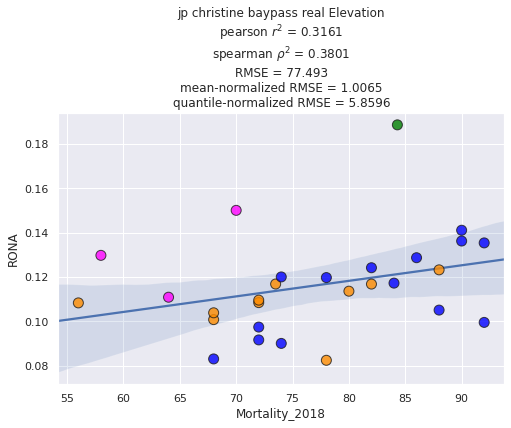

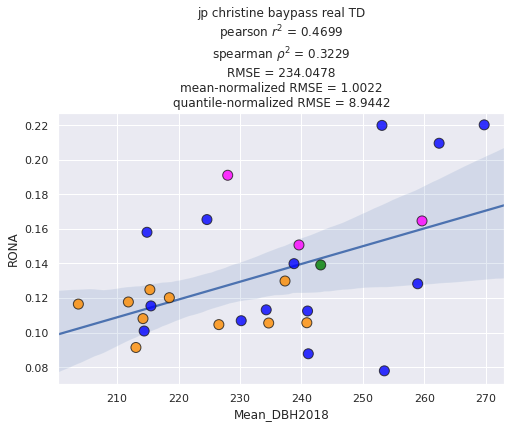

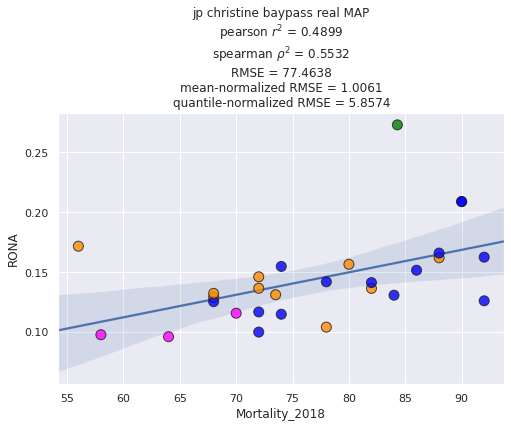

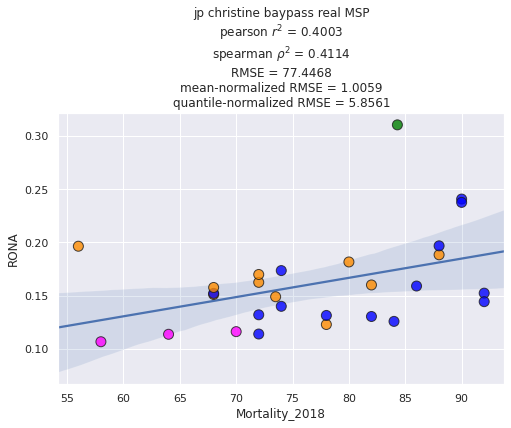

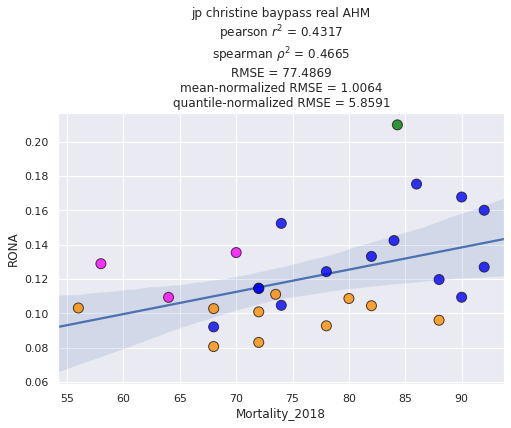

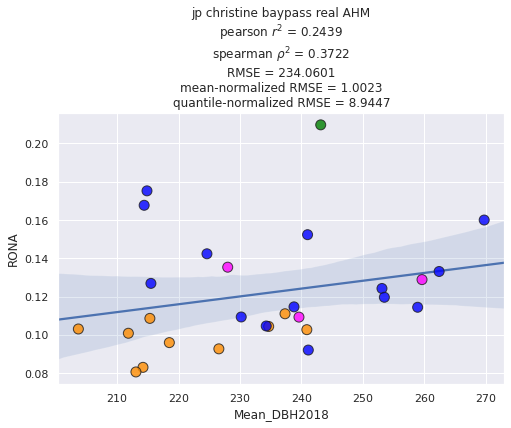

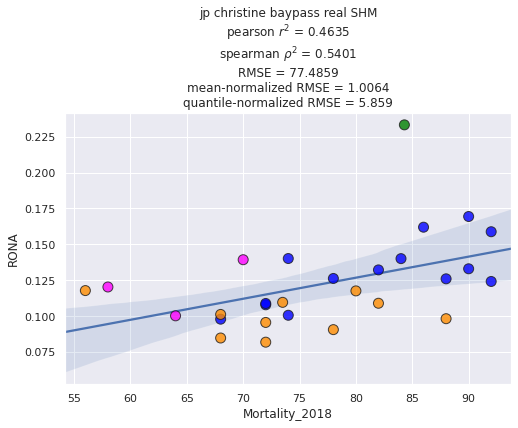

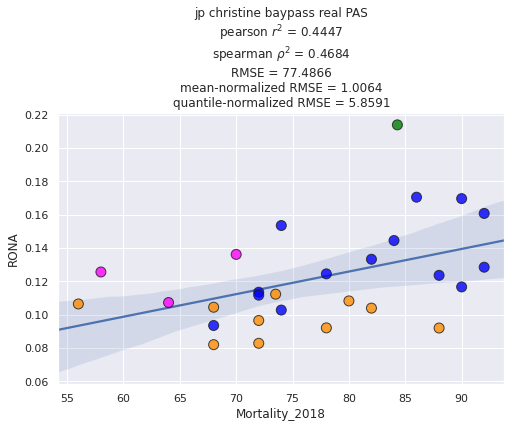

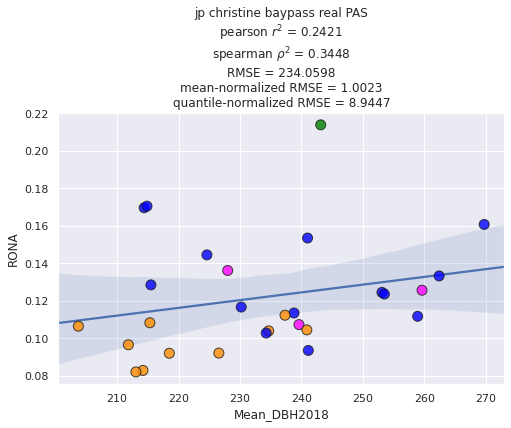

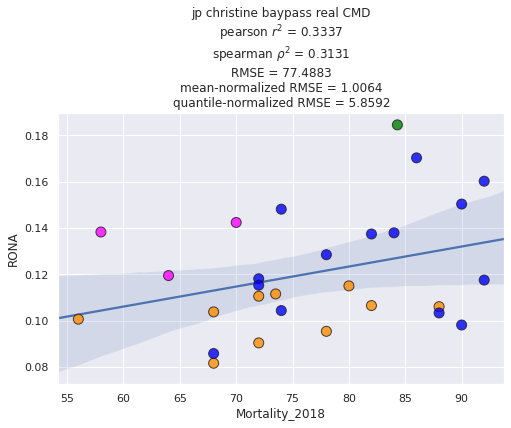

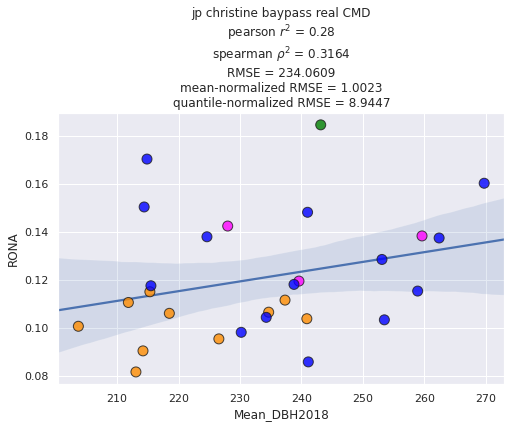

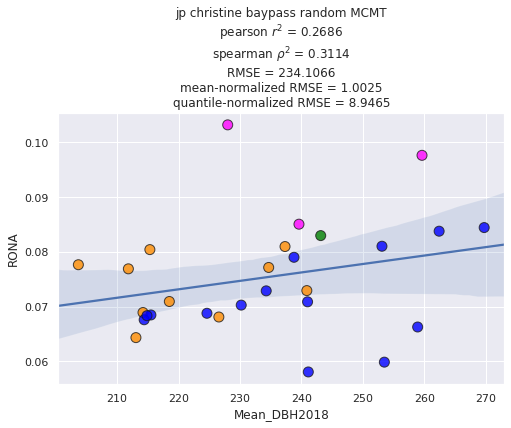

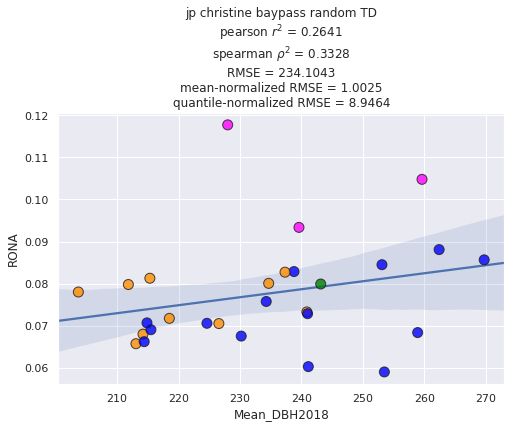

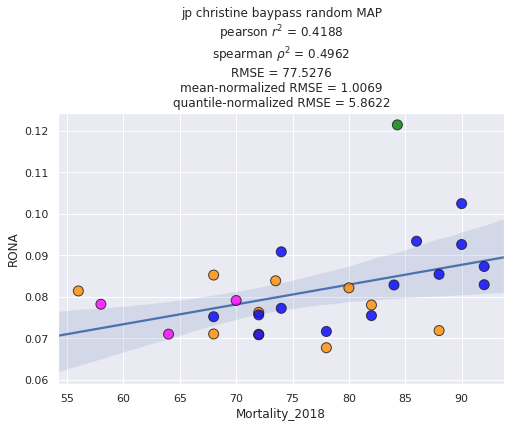

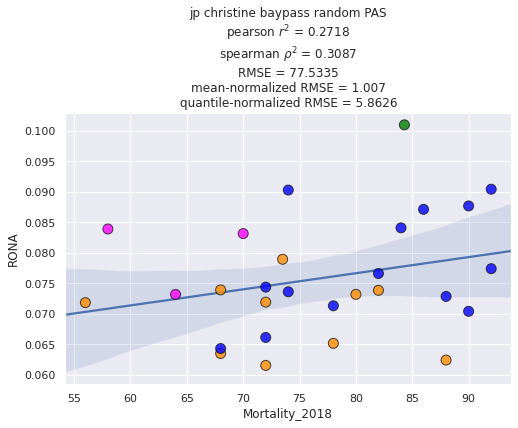

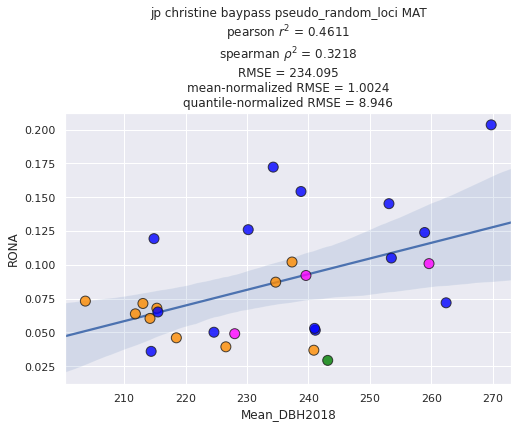

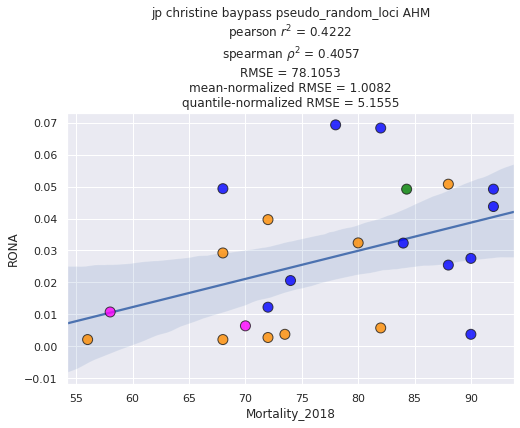

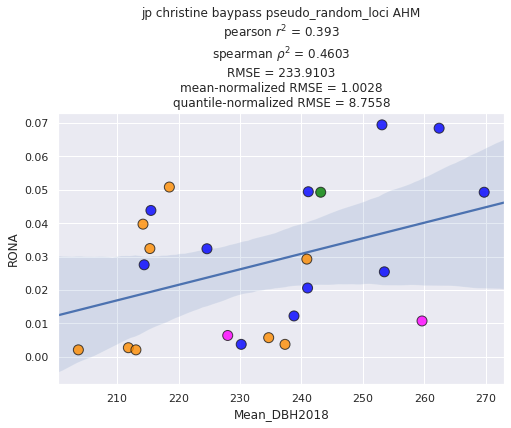

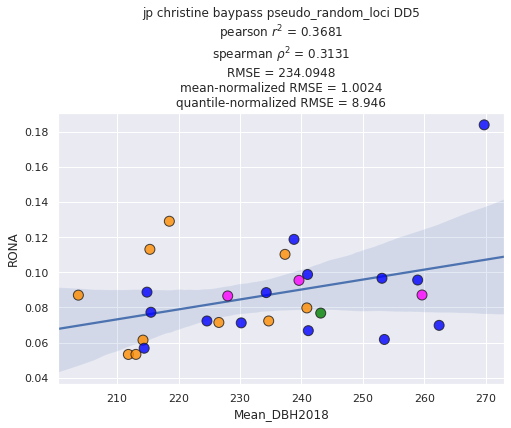

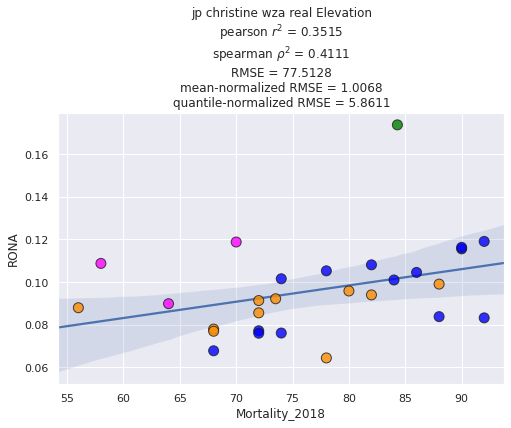

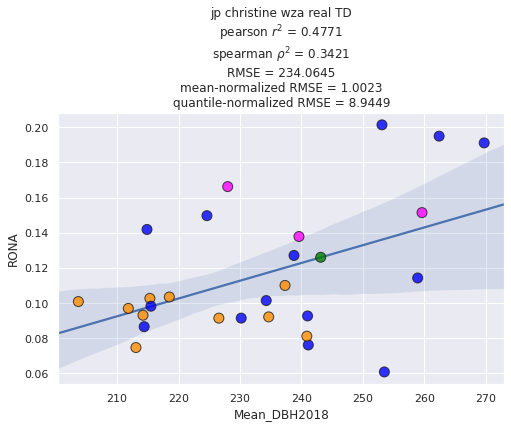

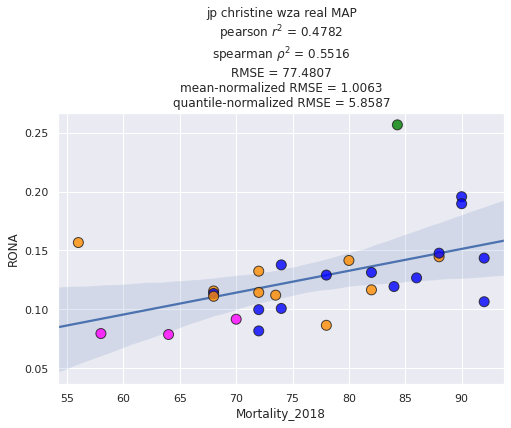

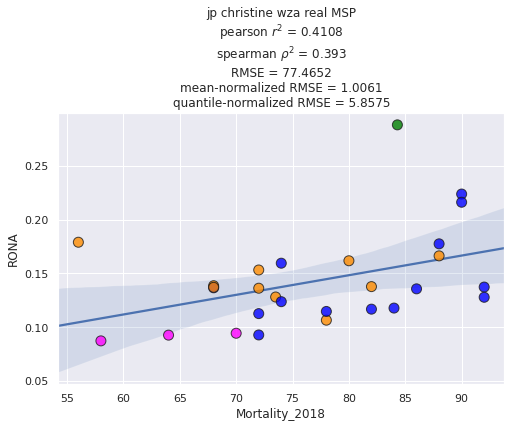

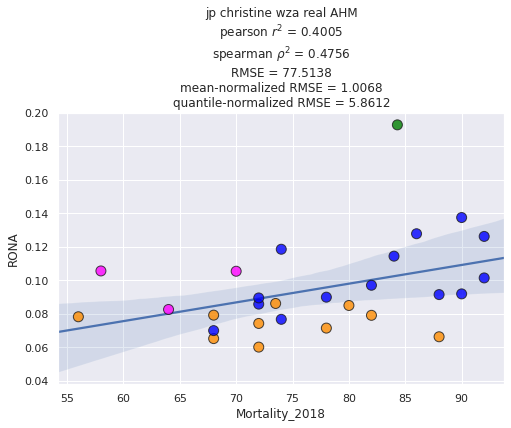

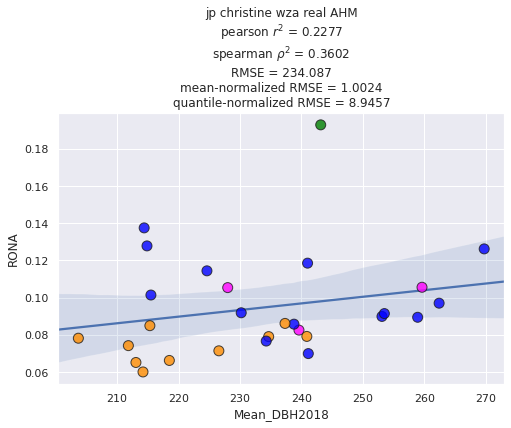

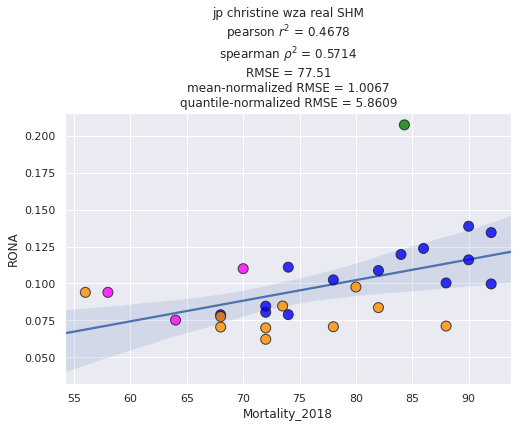

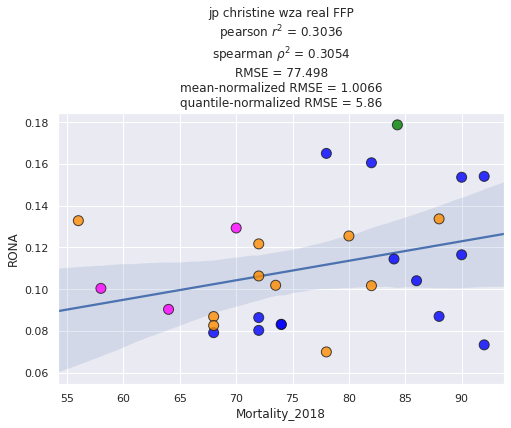

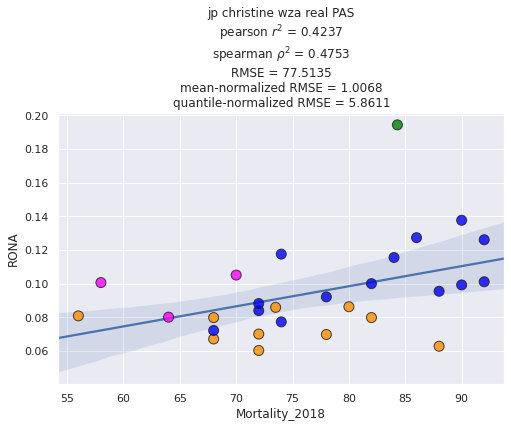

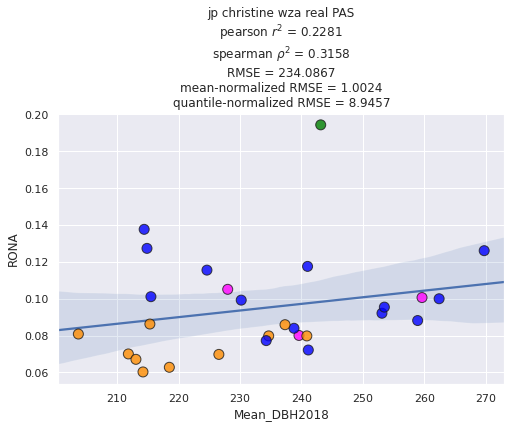

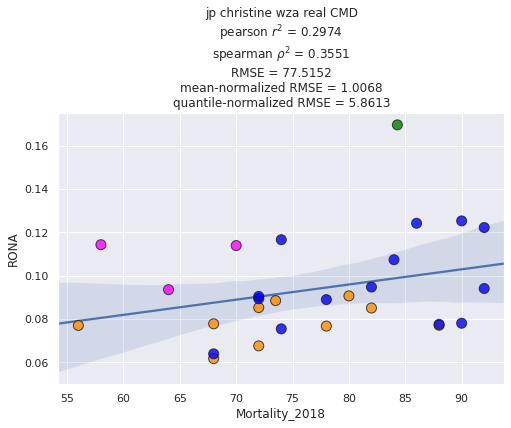

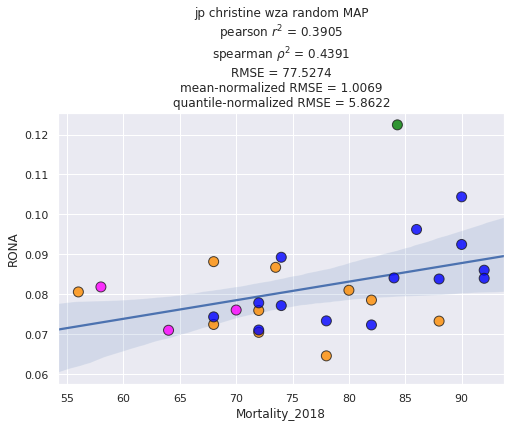

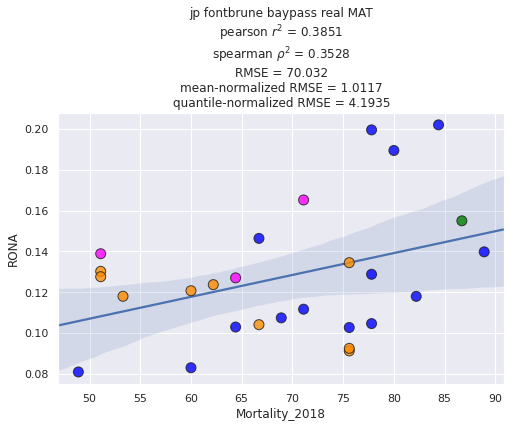

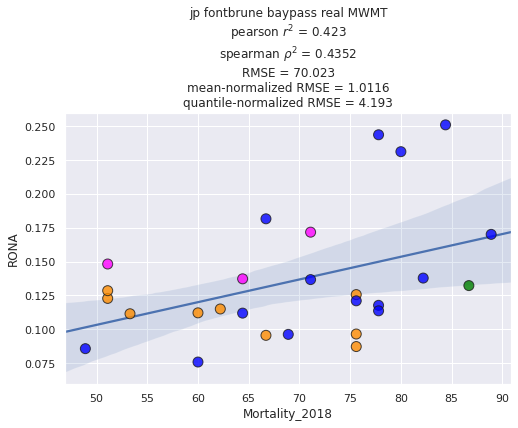

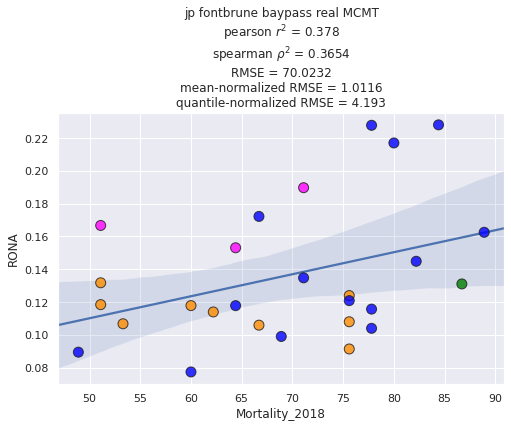

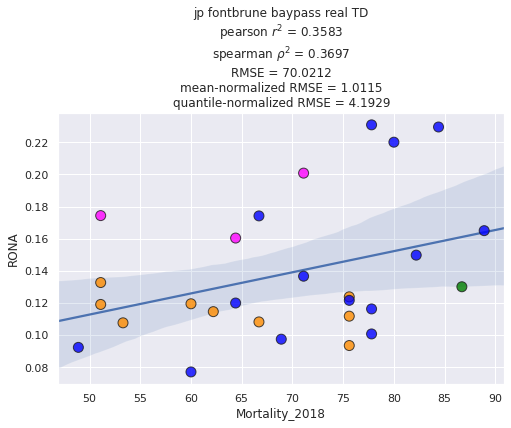

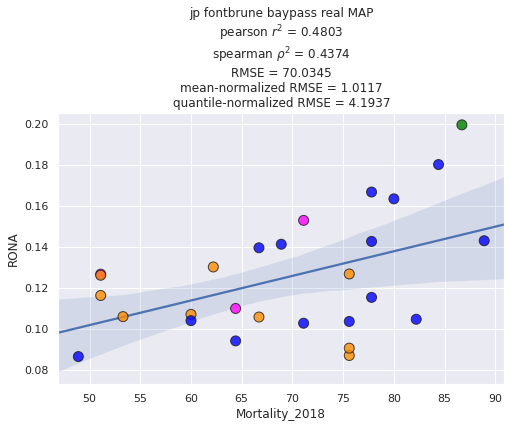

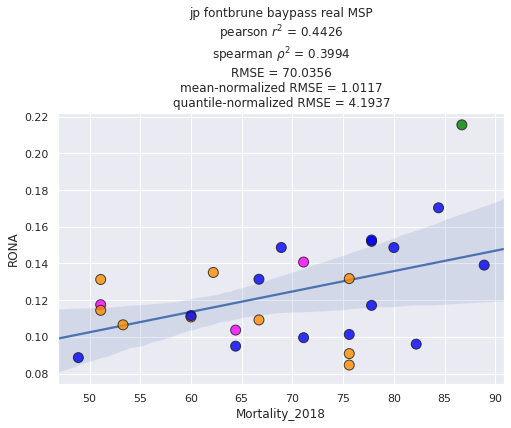

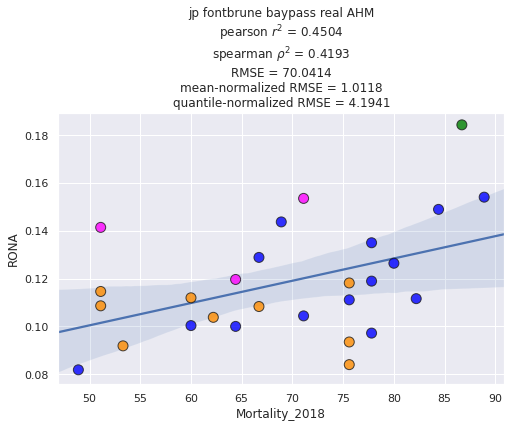

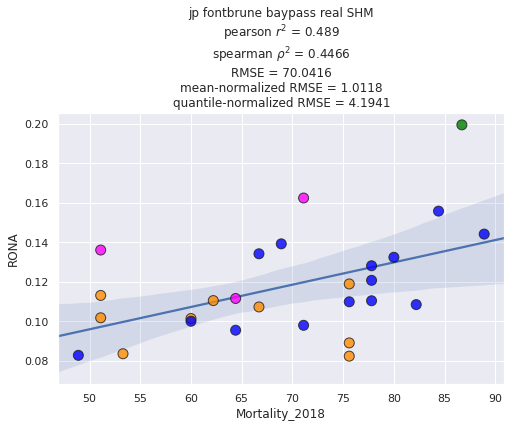

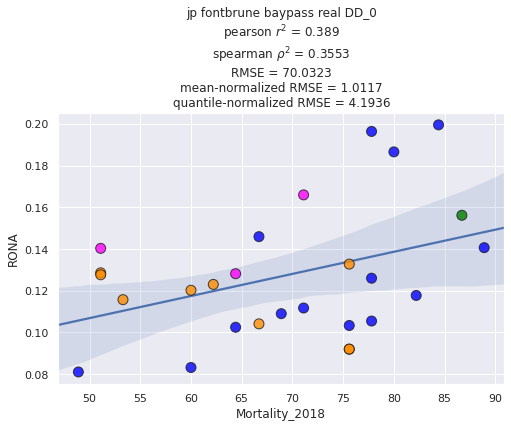

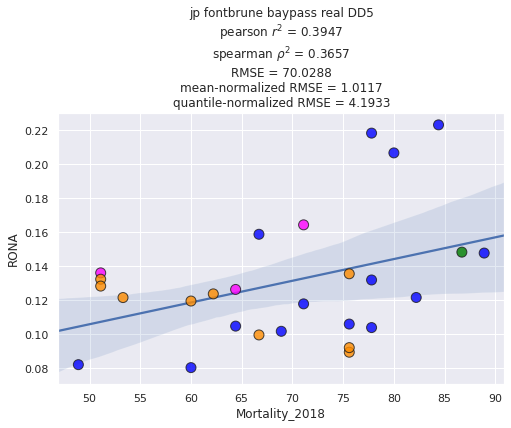

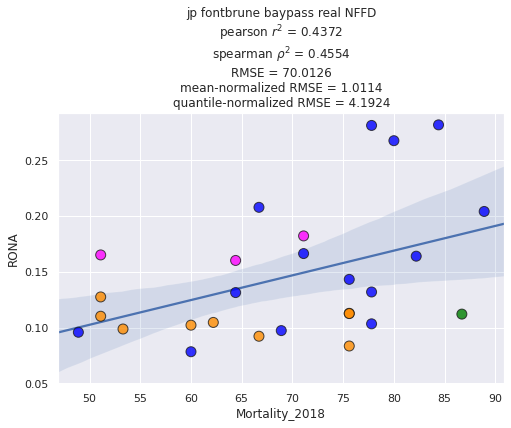

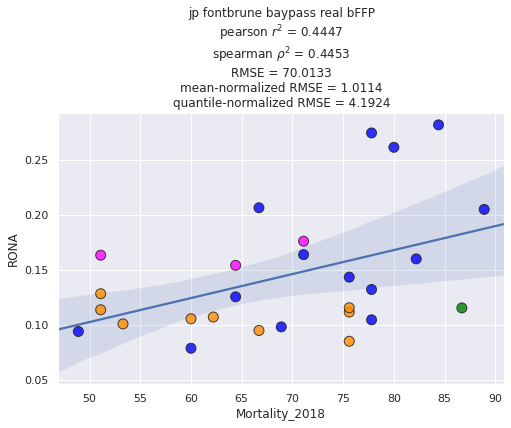

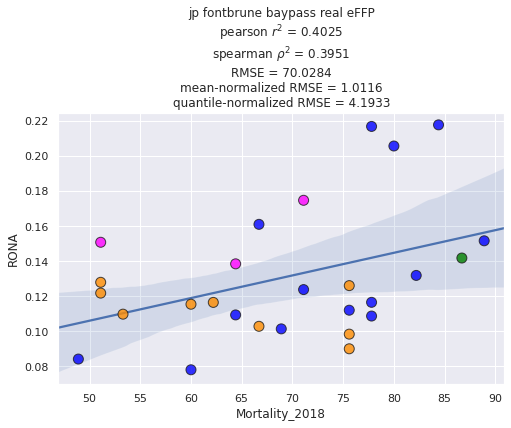

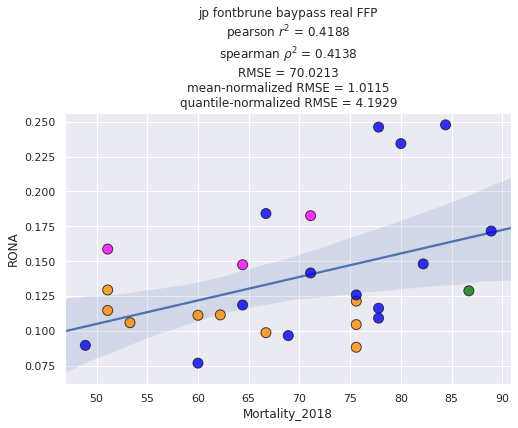

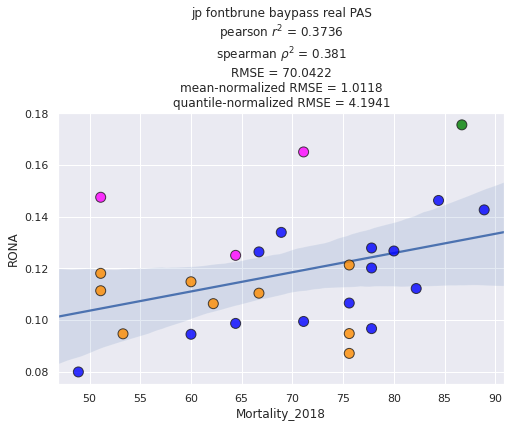

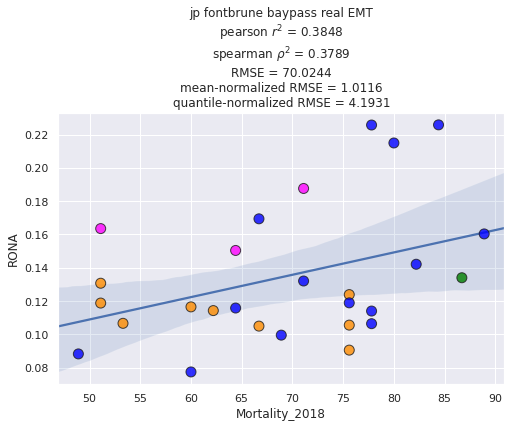

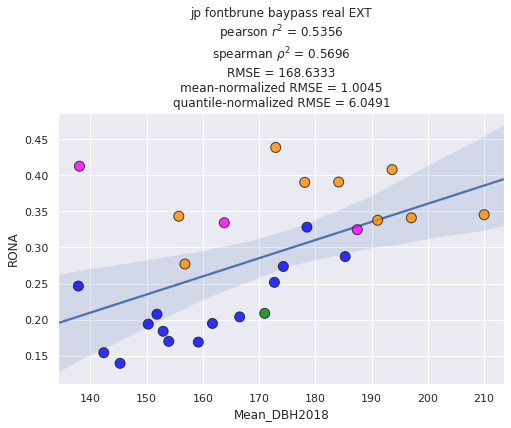

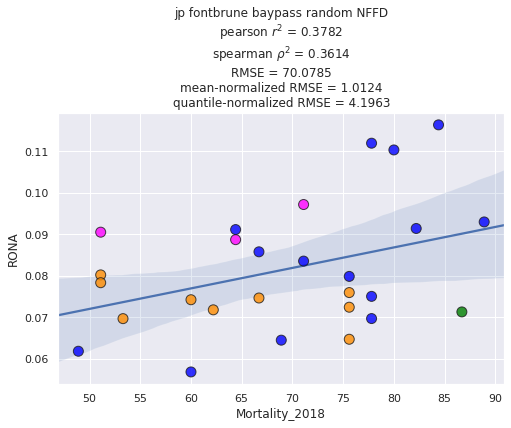

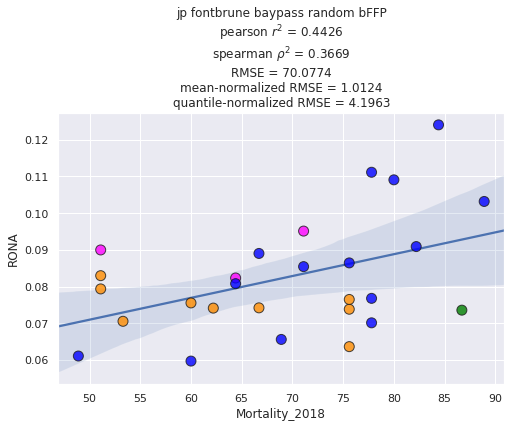

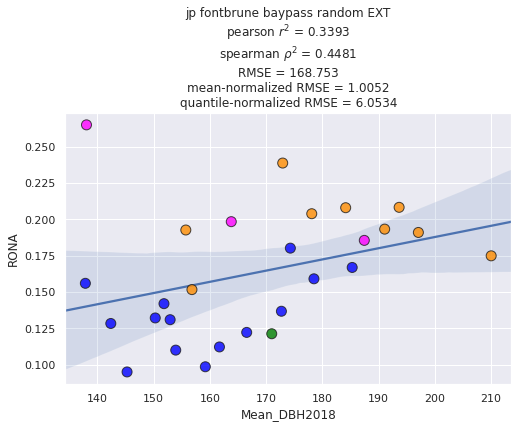

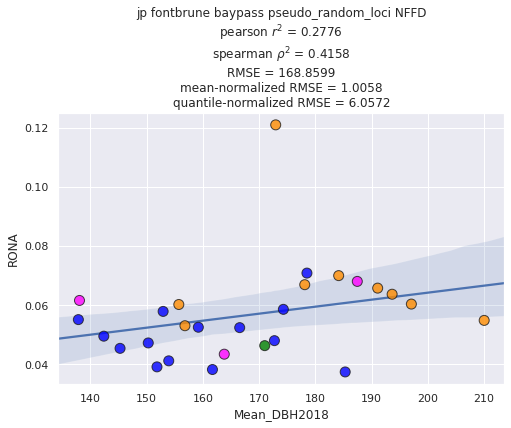

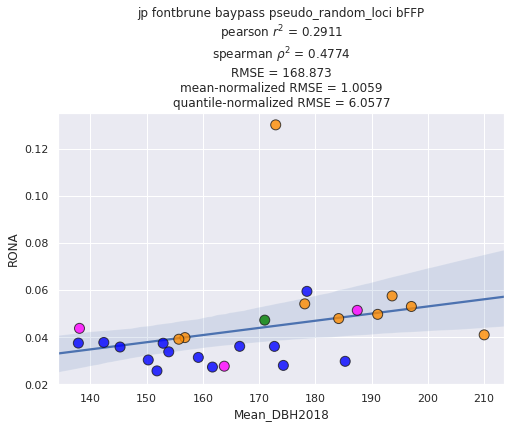

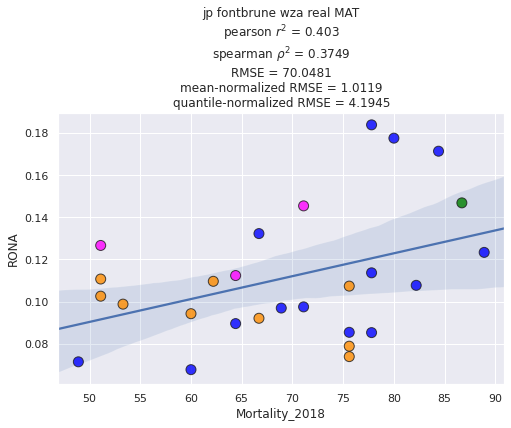

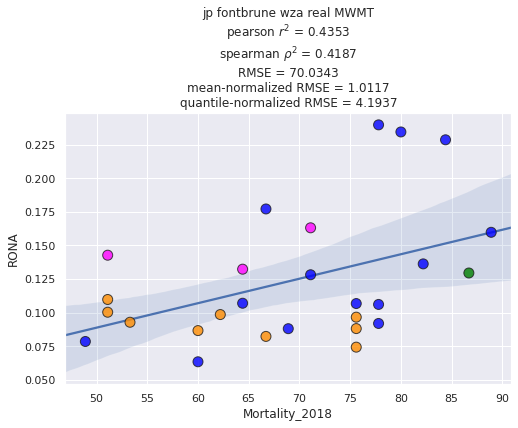

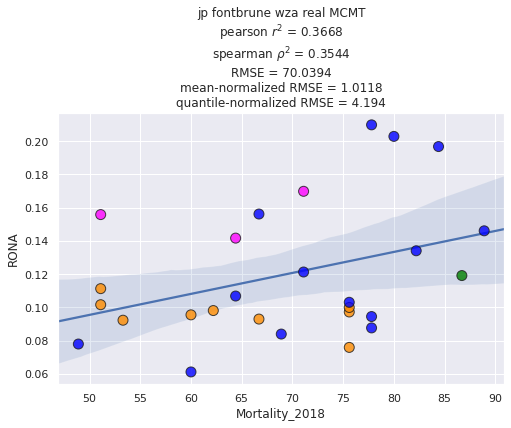

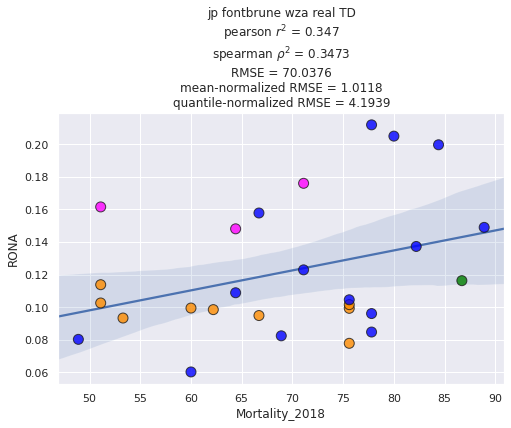

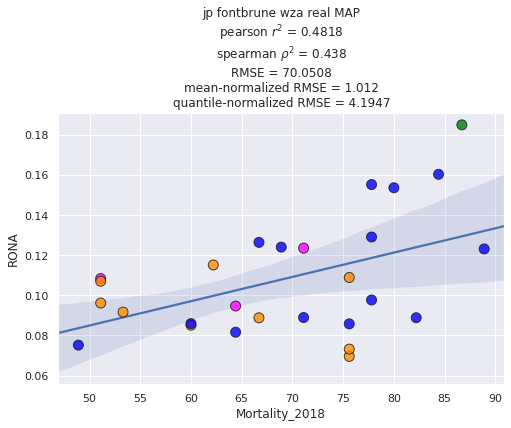

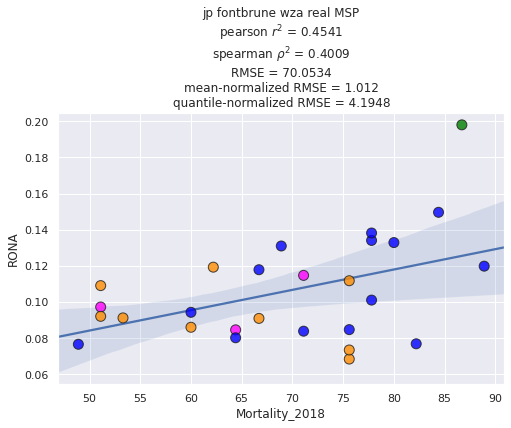

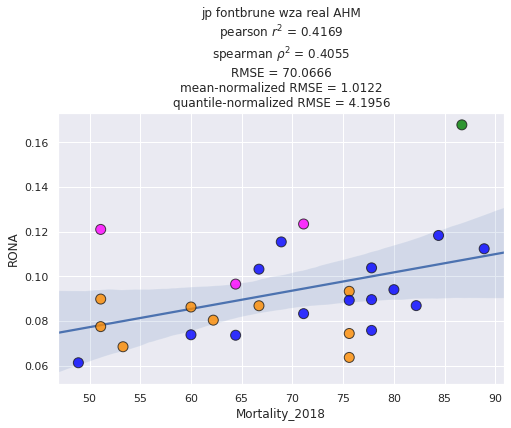

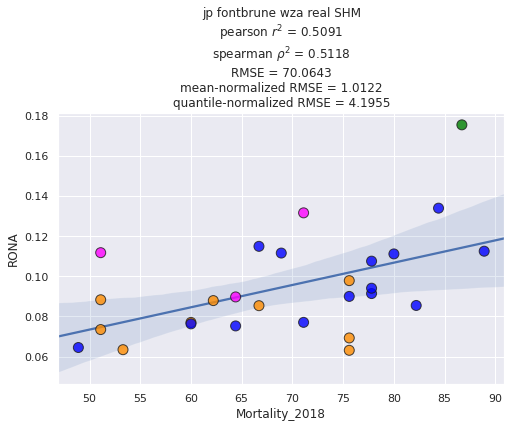

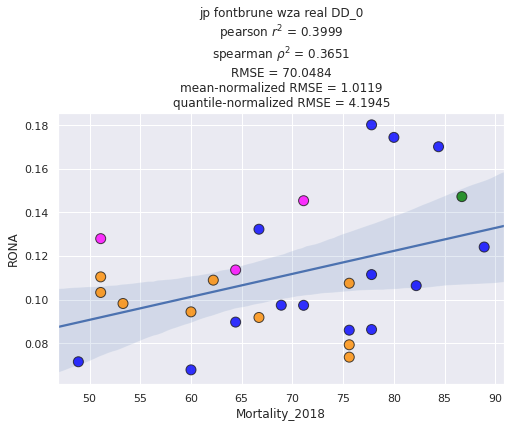

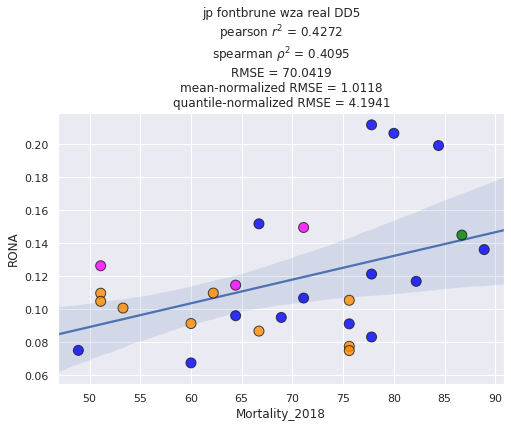

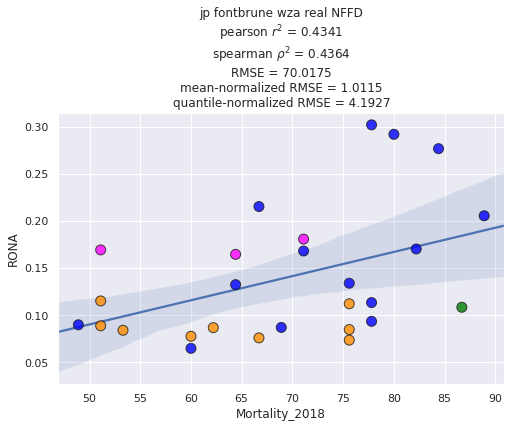

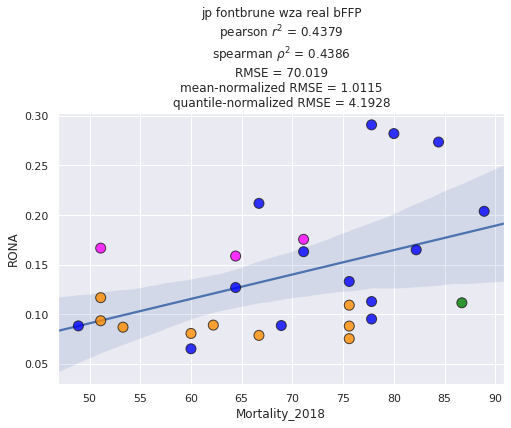

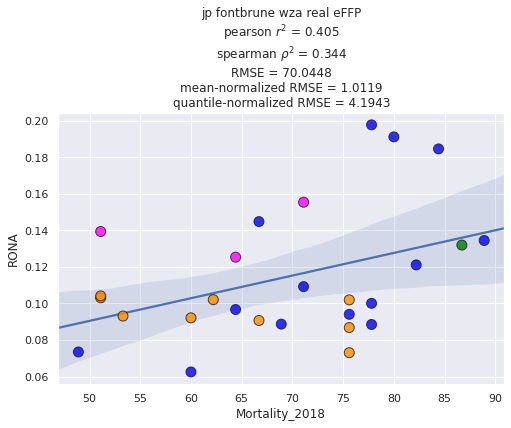

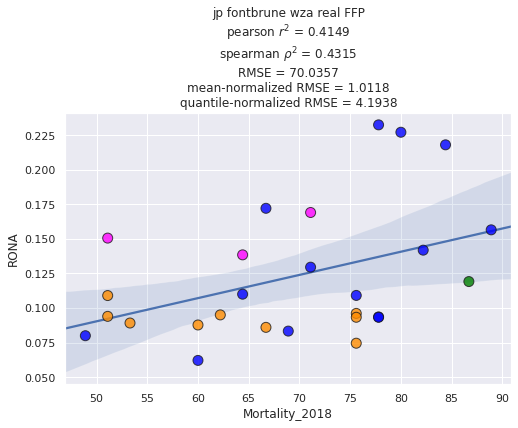

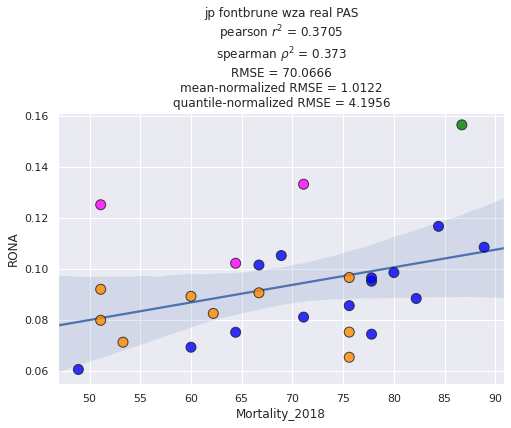

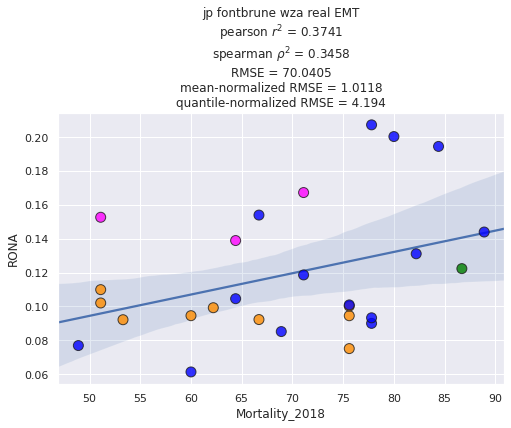

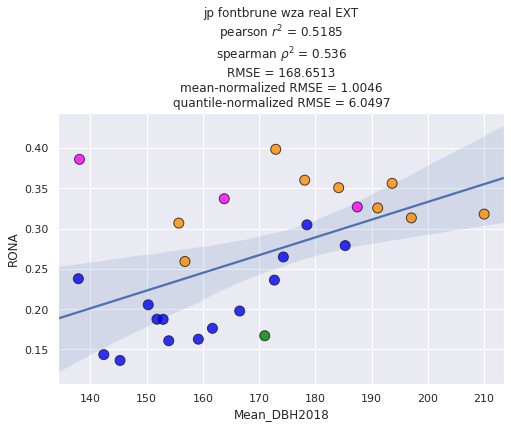

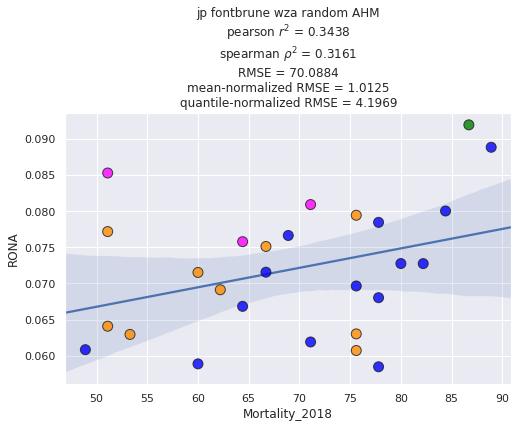

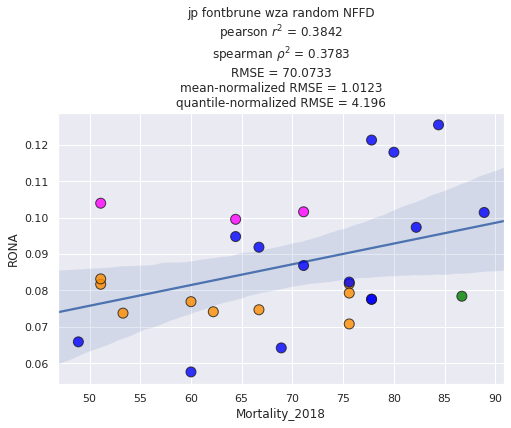

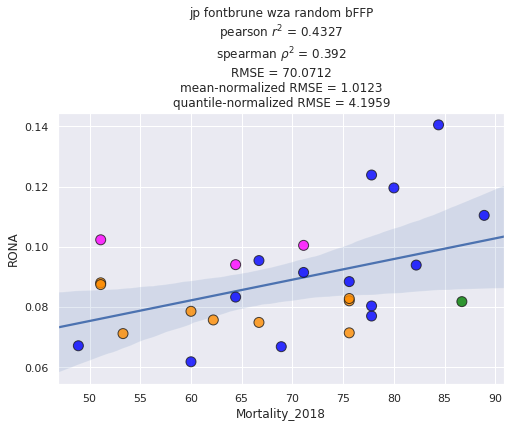

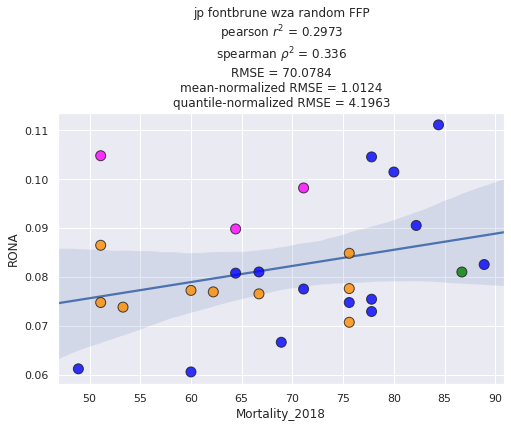

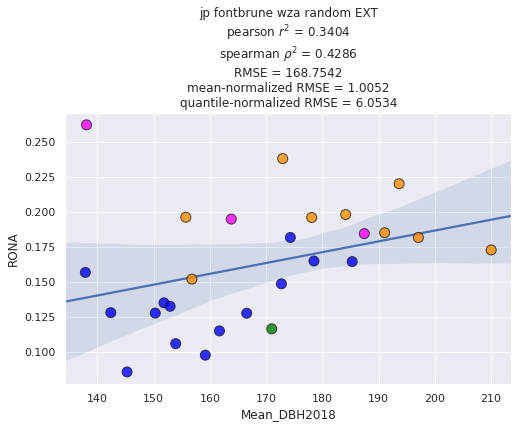

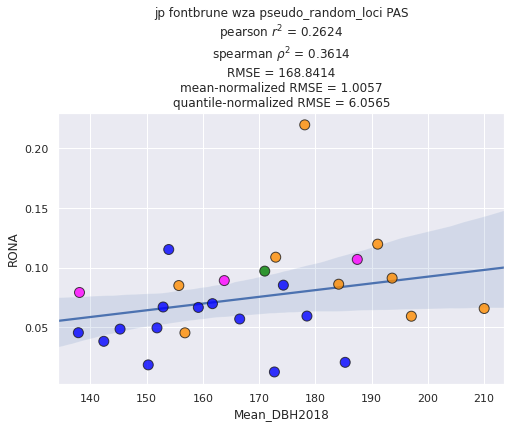

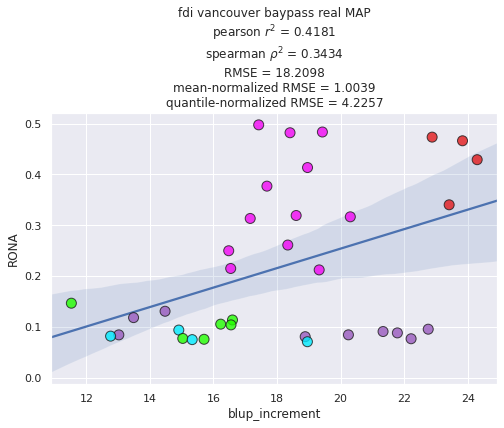

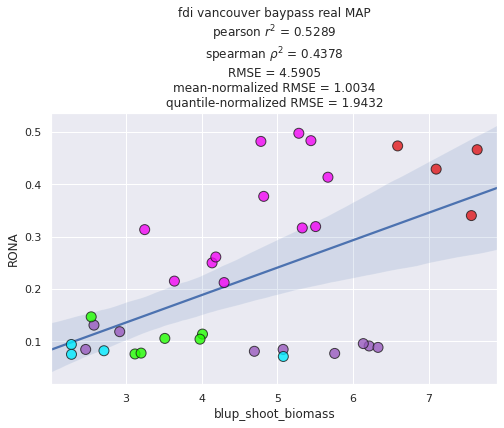

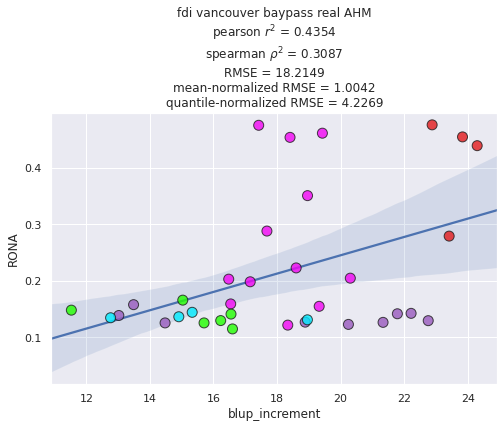

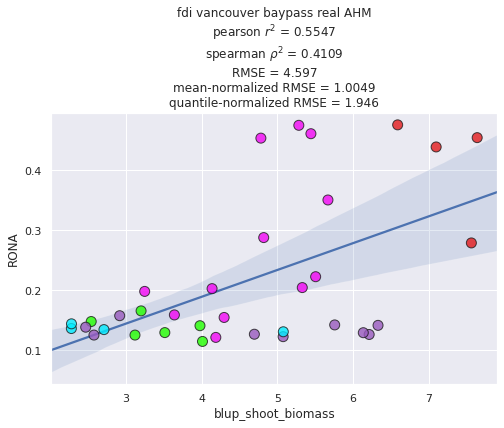

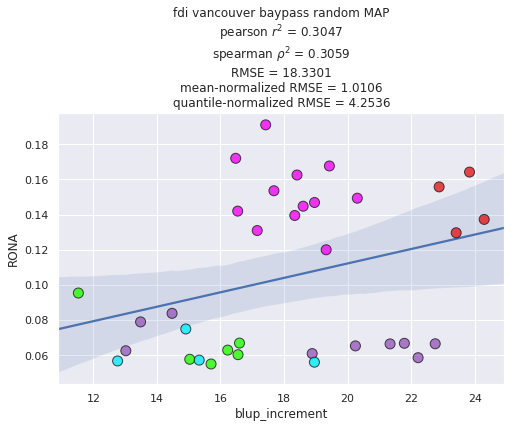

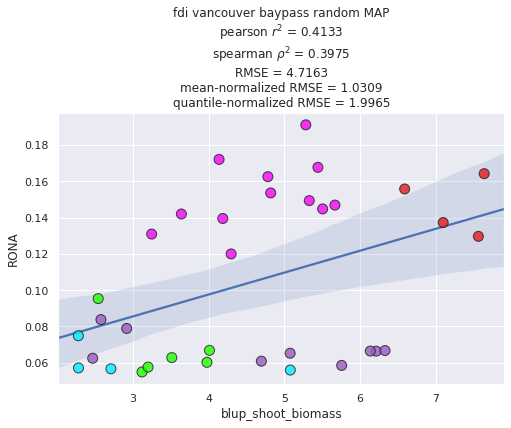

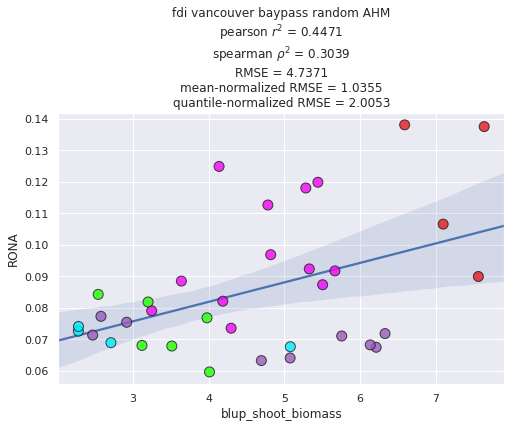

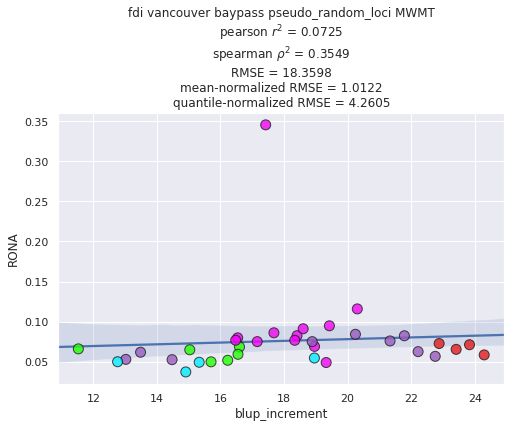

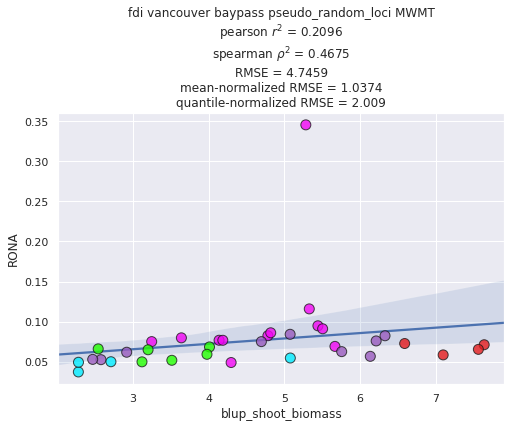

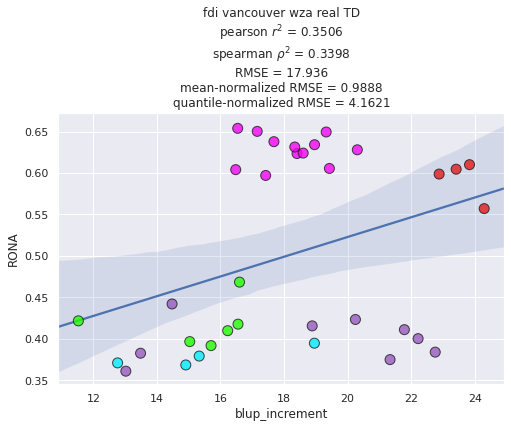

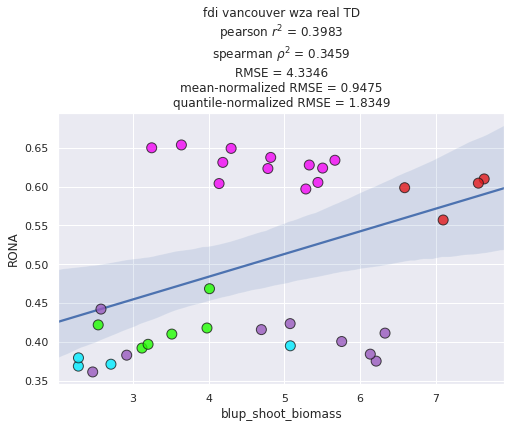

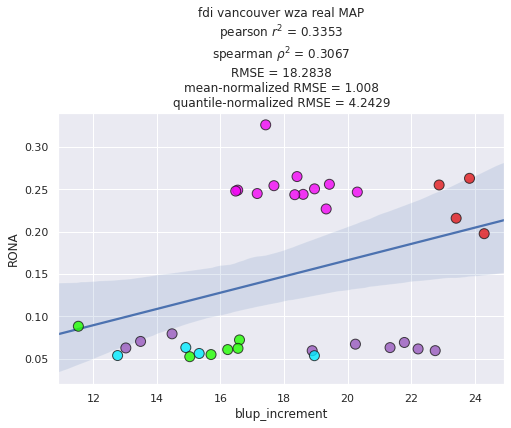

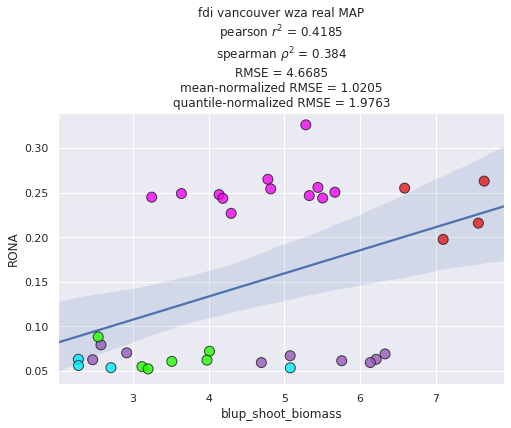

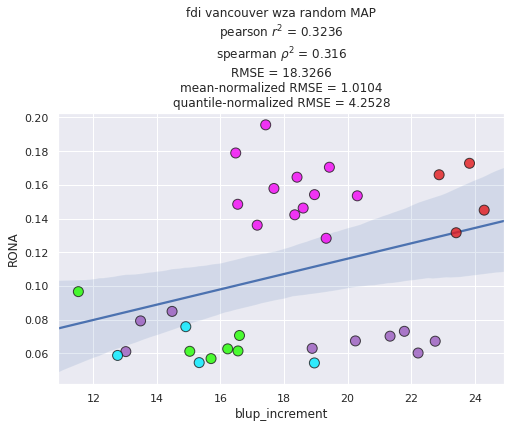

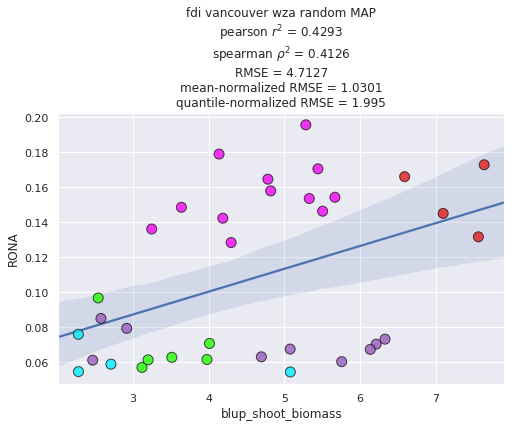

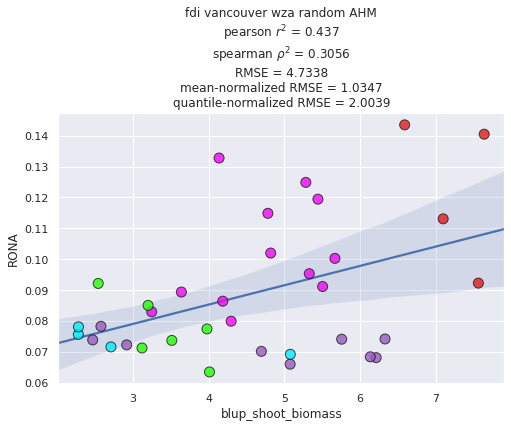

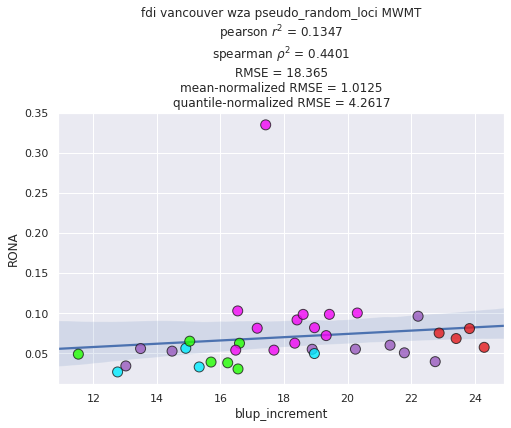

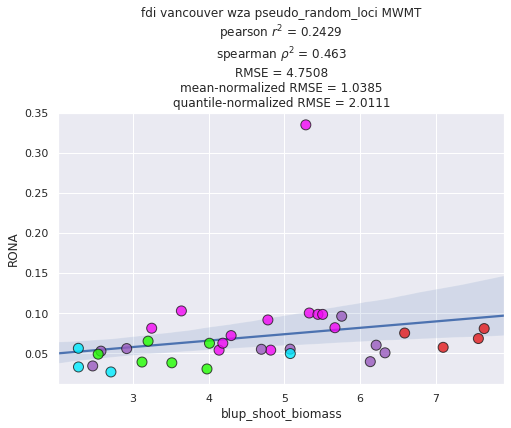

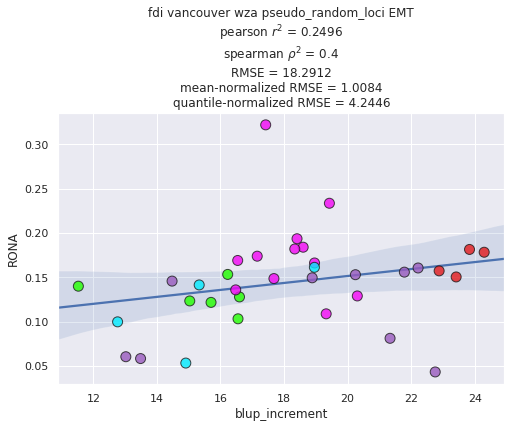

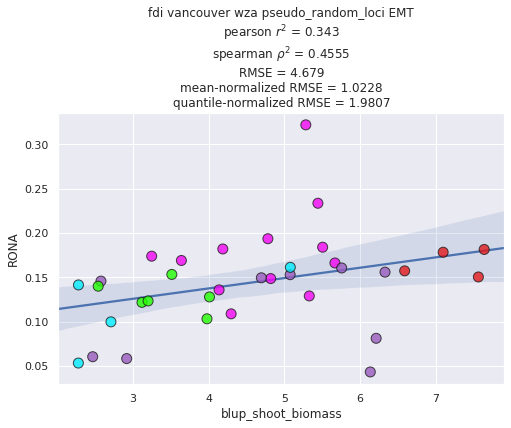

spp     garden   method setname             pheno        env  spearman  \
0  jp  christine  baypass    real    Mortality_2018  Elevation    0.3801   
1  jp  christine  baypass    real  Mean_Height_2018  Elevation   -0.1045   
2  jp  christine  baypass    real      Mean_DBH2018  Elevation    0.1308   
3  jp  christine  baypass    real    Mortality_2018        MAT    0.2615   
4  jp  christine  baypass    real  Mean_Height_2018        MAT   -0.1817   

   pearson       rmse  rmse_mean  rmse_iq       dataset  
0   0.3161    77.4930     1.0065   5.8596  baypass-real  
1  -0.1715  1878.5391     1.0018  15.3768  baypass-real  
2   0.1103   234.0658     1.0023   8.9449  baypass-real  
3   0.2580    77.4842     1.0064   5.8589  baypass-real  
4  -0.1670  1878.5304     1.0018  15.3767  baypass-real

In [56]:
# for a specific species/garden/dataset/locus_set:
    # calculate correlation between pop value and phenotype for all envs - this will be the boxplot
    
# blank dataframe to fill in
cordf = pd.DataFrame(
    columns = [
        'spp', 'garden', 'method', 'setname', 'pheno', 'env', 'spearman', 'pearson', 'rmse', 'rmse_mean', 'rmse_iq'
    ]
)

pears = wrap_defaultdict(None, 5)  # store pearson's correlation coefficient
spears = wrap_defaultdict(None, 5)  # store spearman's correlation coefficient
rmse = wrap_defaultdict(None, 5)  # store root mean error standardized by mean phenotype
for spp in rona.keys():
    for garden in cgdict[spp]:
        for method in methods:  # baypass/wza
            for setname in loci_setnames:  # real/random/pseudo_random
                pheno_spears = defaultdict(list)  # one corr per env, grouped by phenotype
                pheno_pears = defaultdict(list)
                pheno_rmse = defaultdict(list)
                for env in envs:
                    for pheno,phenotypes in phenodata[spp][garden].items():
                        if pheno in exclude_phenos:
                            continue

                        # retrieve rona data
                        ronadata = pd.Series(dtype=float)
                        for pop in phenotypes.index:
                            ronadata.loc[pop] = rona[spp][env][garden][pop][method][setname]

                        # very rarely, a pop returns nan for RONA, so find the pops that don't have nan
                        goodpops = phenotypes.index[
                            np.logical_and(ronadata.notnull(),
                                           phenotypes.notnull())
                        ]
                        
                        if len(goodpops) > 0:  # avoid seaborn complaints
                            r = round(phenotypes.corr(ronadata, method='pearson'),
                                      4)  # pd.Series.corr can handle missing data
                            rho = round(phenotypes.corr(ronadata, method='spearman'),
                                        4)
                            _rmse = calc_rmse(phenotypes, ronadata)
                            rmse_mean = calc_rmse(phenotypes, ronadata, kind='mean')
                            rmse_iq = calc_rmse(phenotypes, ronadata, kind='quantile')
                            if rho > 0.3:
                                # if i should look at/care about it ...
                                plotcolors = [cdict[pop] for pop in goodpops]

                                sns.regplot(x=phenotypes.loc[goodpops],
                                            y=ronadata.loc[goodpops],
                                            truncate=False,
                                            scatter_kws={'color' : plotcolors,
                                                         'zorder' : 5,
                                                         'edgecolor' : 'k',
                                                         's' : 100})
                                title = f'{spp} {garden} {method} {setname} {env}'
                                plt.title('\n'.join([f'{title}',
                                                     f'pearson $r^2$ = {r}',
                                                     f'spearman $\\rho^2$ = {rho}',
                                                     f'RMSE = {_rmse}',
                                                     f'mean-normalized RMSE = {rmse_mean}',
                                                     f'quantile-normalized RMSE = {rmse_iq}']))
                                plt.ylabel(f'RONA')
                                plt.show()
                        else:
                            r = np.nan
                            rho = np.nan
                            _rmse = np.nan
                            rmse_mean = np.nan
                            rmse_iq = np.nan
                        pheno_spears[pheno].append(rho)
                        pheno_pears[pheno].append(r)
                        pheno_rmse[pheno].append(_rmse)
                        cordf.loc[nrow(cordf)] = (
                            spp,garden,method,setname,pheno,env,rho,r,_rmse,rmse_mean,rmse_iq
                        )
                        del _rmse,rmse_mean,rmse_iq

                for pheno in pheno_spears:
                    pears[spp][garden][method][setname][pheno] = pheno_pears[pheno]
                    spears[spp][garden][method][setname][pheno] = pheno_spears[pheno]
                    rmse[spp][garden][method][setname][pheno] = pheno_rmse[pheno]

cordf['dataset'] = cordf['method'].str.cat(cordf['setname'], sep='-')
cordf.head()

In [57]:
corfile = op.join(ronadir, 'correlations.txt')
cordf.to_csv(corfile, sep='\t', index=False)

In [58]:
pearfile = op.join(ronadir, 'rona_pearson.pkl')
pkldump(pears, pearfile)

In [59]:
cordf.head()

spp     garden   method setname             pheno        env  spearman  \
0  jp  christine  baypass    real    Mortality_2018  Elevation    0.3801   
1  jp  christine  baypass    real  Mean_Height_2018  Elevation   -0.1045   
2  jp  christine  baypass    real      Mean_DBH2018  Elevation    0.1308   
3  jp  christine  baypass    real    Mortality_2018        MAT    0.2615   
4  jp  christine  baypass    real  Mean_Height_2018        MAT   -0.1817   

   pearson       rmse  rmse_mean  rmse_iq       dataset  
0   0.3161    77.4930     1.0065   5.8596  baypass-real  
1  -0.1715  1878.5391     1.0018  15.3768  baypass-real  
2   0.1103   234.0658     1.0023   8.9449  baypass-real  
3   0.2580    77.4842     1.0064   5.8589  baypass-real  
4  -0.1670  1878.5304     1.0018  15.3767  baypass-real

In [60]:
spearfile = op.join(ronadir, 'rona_spearman.pkl')
pkldump(spears, spearfile)

In [61]:
rmsefile = op.join(ronadir, 'rmse.pkl')
pkldump(rmse, rmsefile)

<a id='factors'></a>
# 7. Determine environmental factors ($EF_{future}$) to use to validate RONA

- In Rellstab et al. 2016, they determined the environmental factors to use to calculate rona by using paired $t$ tests between current and future climate, and keeping the top three envs after ranking by p-value.


- Here, I do this but use the common garden data in place of a 'future' climate.


- I will also see how the choice of environments affects RONA agreement with garden data - see `../08_climate_and_geographic_distance_vs_phenotypes`:
    1. all climate vars
    2. those climate vars used by British Columbia's climate-based seed transfer
    3. those climate vars shown to explain significant variation in the common garden trials of these species
        The climate variables for the transfer function used to best predict lodgepole pine height was MAT (>64% var exp) and ln(AHM)  (> 6%).
        
            Wang T, Hanann A, Yanchuk A, O’Neill GA, Aitken SN. 2006. Use of response functions in selecting lodgepole pine populations for future climates. Global Change Biol 12:2404–2416.
 
        For Douglas-fir, it is MAT, SHM, and TD – though MAT alone explained the vast majority of variation (77-92% depending on phenotype)s.
        
            Chakraborty D, Wang T, Andre K, Konnert M, Lexer MJ, Matulla C, Schueler S. 2015. Selecting Populations for Non-Analogous Climate Conditions Using Universal Response Functions: The Case of Douglas-Fir in Central Europe. Plos One 10:e0136357.
        
    4. WZA vars - the subset of climate vars that are being used for WZA

[top](#home)

### get canonical environmental factors (i.e., with t-tests as in Rellstab et al. 2016)

In [62]:
pd.DataFrame(cgdata.loc[garden, envs]).T

Elevation   MAT   MWMT  MCMT     TD     MAP    MSP    AHM    SHM  \
vancouver       81.0  11.2  19.65   5.4  14.25  1194.0  259.0  18.05  76.65   

           DD_0     DD5   NFFD  bFFP   eFFP    FFP   PAS   EMT   EXT   Eref  \
vancouver  86.5  2487.5  320.5  60.0  322.0  262.0  36.0 -13.5  35.0  648.0   

             CMD  
vancouver  301.0

In [63]:
# get p-values from paired t tests, show what `gardendata` looks like
ef_futs = wrap_defaultdict(None, 3)
for spp,envdf in envdata.items():
    for garden in cgdict[spp]:
        # create 'future' data for each pop using the common garden climate
        gardendata = pd.concat([pd.DataFrame(cgdata.loc[garden, envs]).T for i in range(nrow(envdf))])
        gardendata.index = envdf.index.tolist()
        for env in envs:
            t,p = ttest_rel(gardendata[env], envdf[env])
            ef_futs[spp][garden][env] = p
            
gardendata.head()

Elevation   MAT   MWMT  MCMT     TD     MAP    MSP    AHM    SHM  DD_0  \
DF_p3       81.0  11.2  19.65   5.4  14.25  1194.0  259.0  18.05  76.65  86.5   
DF_p4       81.0  11.2  19.65   5.4  14.25  1194.0  259.0  18.05  76.65  86.5   
DF_p5       81.0  11.2  19.65   5.4  14.25  1194.0  259.0  18.05  76.65  86.5   
DF_p7       81.0  11.2  19.65   5.4  14.25  1194.0  259.0  18.05  76.65  86.5   
DF_p8       81.0  11.2  19.65   5.4  14.25  1194.0  259.0  18.05  76.65  86.5   

          DD5   NFFD  bFFP   eFFP    FFP   PAS   EMT   EXT   Eref    CMD  
DF_p3  2487.5  320.5  60.0  322.0  262.0  36.0 -13.5  35.0  648.0  301.0  
DF_p4  2487.5  320.5  60.0  322.0  262.0  36.0 -13.5  35.0  648.0  301.0  
DF_p5  2487.5  320.5  60.0  322.0  262.0  36.0 -13.5  35.0  648.0  301.0  
DF_p7  2487.5  320.5  60.0  322.0  262.0  36.0 -13.5  35.0  648.0  301.0  
DF_p8  2487.5  320.5  60.0  322.0  262.0  36.0 -13.5  35.0  648.0  301.0

In [64]:
# show top 5 envs (sorted by p-value) for each spp for each garden
canonical_efs = defaultdict(dict)
for spp,gardendict in ef_futs.items():
    for garden,pdict in gardendict.items():
        print(ColorText(f'{spp} {garden}').bold().blue())
        df = pd.DataFrame(pdict, index=[garden]) \
            .T \
            .sort_values(by=garden, ascending=True) \
            .iloc[:5]
        
        canonical_efs[spp][garden] = df.index.tolist()
        display(df)
canonical_efs[spp][garden]

jp christine


christine
EXT        1.084316e-27
MSP        9.095524e-16
MAP        5.559867e-12
SHM        5.607879e-10
Elevation  7.337828e-09

jp fontbrune


fontbrune
EXT  1.229238e-25
MSP  1.640940e-07
SHM  3.166373e-06
AHM  2.229745e-05
MAP  2.495356e-05

combined vancouver


vancouver
bFFP  3.134143e-44
FFP   6.294516e-37
NFFD  2.498133e-27
eFFP  9.501555e-27
DD5   4.645407e-26

fdc vancouver


vancouver
bFFP  1.312699e-21
FFP   1.996474e-18
eFFP  2.866360e-12
NFFD  3.582954e-12
EMT   6.254842e-12

fdi vancouver


vancouver
bFFP  3.205920e-32
FFP   1.292912e-31
eFFP  6.564966e-30
NFFD  8.936509e-30
TD    1.051689e-29

['bFFP', 'FFP', 'eFFP', 'NFFD', 'TD']

In [65]:
canonical_efs

defaultdict(dict,
            {'jp': {'christine': ['EXT', 'MSP', 'MAP', 'SHM', 'Elevation'],
              'fontbrune': ['EXT', 'MSP', 'SHM', 'AHM', 'MAP']},
             'combined': {'vancouver': ['bFFP', 'FFP', 'NFFD', 'eFFP', 'DD5']},
             'fdc': {'vancouver': ['bFFP', 'FFP', 'eFFP', 'NFFD', 'EMT']},
             'fdi': {'vancouver': ['bFFP', 'FFP', 'eFFP', 'NFFD', 'TD']}})

### other environmental factor groups

In [66]:
# the climate variables used by British Columbia's climate-based seed transfer
_efs = ['MAT', 'MCMT', 'TD', 'MAP', 'MSP', 'DD5', 'EMT']
cbst_efs = {
    'jp' : {'christine' : _efs,
            'fontbrune' : _efs},
    'fdc' : {'vancouver' : _efs},
    'fdi' : {'vancouver' : _efs},
    'combined' : {'vancouver' : _efs}
}

In [67]:
# climate variables of origin explaining significant variation in provinance trials for each species
# see refs at top
prov_efs = {
    'jp' : {'christine' : ['MAT', 'SHM', 'TD'],
            'fontbrune' : ['MAT', 'SHM', 'TD']},
    'fdi' : {'vancouver' : ['MAT', 'AHM']},
    'fdc' : {'vancouver' : ['MAT', 'AHM']},
    'combined' : {'vancouver' : ['MAT', 'AHM']}
}

In [68]:
# WZA vars used in convergence paper (all but LAT)
_wza = ['MAT', 'MCMT', 'MSP', 'PAS', 'SHM', 'Elevation', 'FFP']
wza_efs = {
    'jp' : {'christine' : _wza,
            'fontbrune' : _wza},
    'fdi' : {'vancouver' : _wza},
    'fdc' : {'vancouver' : _wza},
    'combined' : {'vancouver' : _wza}
}

In [69]:
# combine climate dicts into one dict
efdict = {'canonical' :  canonical_efs,
          'CBST' : cbst_efs,
          'provenance_trial' : prov_efs,
          'WZA' : wza_efs
         }

pkldump(efdict, op.join(ronadir, 'efdict.pkl'))

<a id='ef_figs'></a>
### see how loci counts differ when considering specific groups of environmental factors (`efdict`)

[back to figs using all environmental factors](#efdict)

In [70]:
# all_counts[spp][garden][method][setname][env]

In [71]:
# determine the number of loci behind each of the RONA calculations
num_loci_counts = pd.DataFrame(columns=['spp', 'garden', 'method', 'setname', 'ef_setname', 'num_loci', 'mean_count', 'min_count', 'max_count'])
for spp,gardendict in all_counts.items():
    for garden,methoddict in pbar(gardendict.items(), desc=spp):
        for method,setdict in methoddict.items():
            for setname,envdict in setdict.items():
                for ef_setname,ef_setdict in efdict.items():
                    # number of unique loci across envs in method-setname that have sig linear models
                    num_loci = luni(
                        [locus for env in ef_setdict[spp][garden] for poploci in envdict[env] for locus in poploci]
                    )
                    # number of loci per env for method-setname that have sig linear models
                    loci_counts = [
                        uni([len(poploci) for poploci in envdict[env]])[0] for env in ef_setdict[spp][garden]
                    ]
                    # average number of loci per env for method-setname that have sig linear models
                    mean_count = np.mean(loci_counts)
                    title = f'{ef_setname} {spp} {garden} {method} {setname}\nmean = {mean_count}\n{num_loci = }\n'
#                     print(title)
                    num_loci_counts.loc[nrow(num_loci_counts)] = spp,garden,method,setname,ef_setname,num_loci,mean_count,min(loci_counts),max(loci_counts)
num_loci_counts.head()

combined: 100%|███████████████| 1/1 [00:11<00:00, 11.34s/it]


spp     garden   method             setname        ef_setname num_loci  \
0  jp  christine  baypass  pseudo_random_loci         canonical      582   
1  jp  christine  baypass  pseudo_random_loci              CBST       91   
2  jp  christine  baypass  pseudo_random_loci  provenance_trial       52   
3  jp  christine  baypass  pseudo_random_loci               WZA      293   
4  jp  christine  baypass              random         canonical     8399   

    mean_count min_count max_count  
0   119.200000         0       318  
1    17.857143         3        49  
2    17.333333         0        49  
3    43.000000         0       253  
4  3571.400000      1908      5166

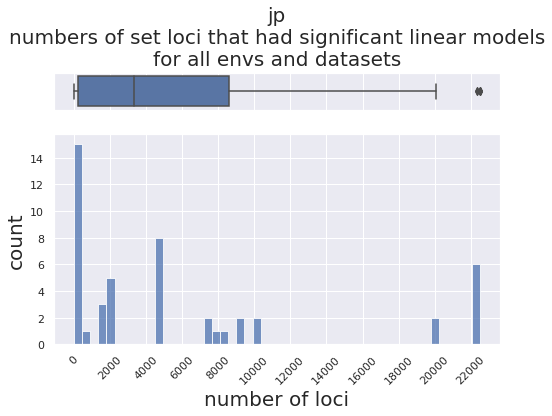

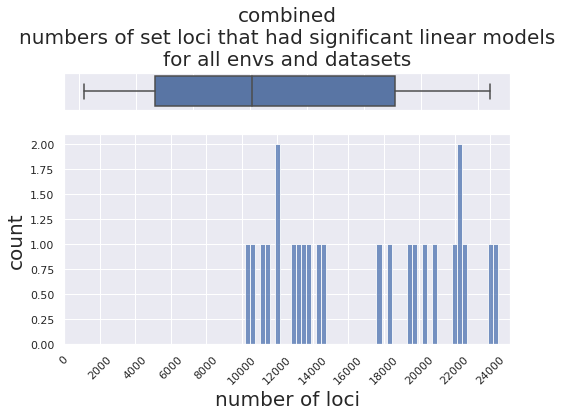

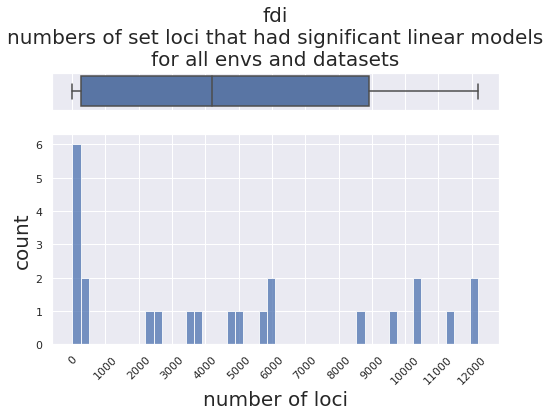

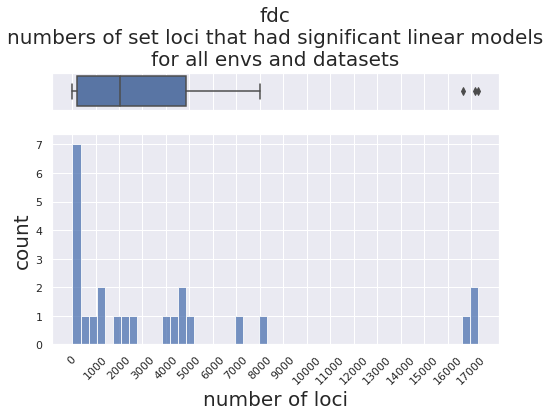

In [72]:
# distribution of set loci with significant linear models used in the RONA calculations

# figure out xticks
for spp in uni(num_loci_counts['spp']):
    sppdf = num_loci_counts[num_loci_counts['spp']==spp]
    
    digits = len(str(max(sppdf['num_loci']))) - 2 
    xtick = round(max(sppdf['num_loci'])/13, -digits)
    if xtick < 10:
        xtick = 10

    histo_box(sppdf['num_loci'].tolist(),
              xlab=f'number of loci',
              ylab='count',
              title='\n'.join([spp,
                               'numbers of set loci that had significant linear models',
                               'for all envs and datasets']),
              xticks_by=xtick,
              rotation=45,
              histbins=50
             )
    plt.show()

In [73]:
# combine data
all_num_loci_counts = pd.concat([_x, num_loci_counts]).sort_values(by=['spp', 'garden', 'method', 'setname', 'ef_setname'])
all_num_loci_counts.head(10)

spp     garden   method             setname        ef_setname  \
97   combined  vancouver  baypass  pseudo_random_loci              CBST   
99   combined  vancouver  baypass  pseudo_random_loci               WZA   
24   combined  vancouver  baypass  pseudo_random_loci               all   
96   combined  vancouver  baypass  pseudo_random_loci         canonical   
98   combined  vancouver  baypass  pseudo_random_loci  provenance_trial   
101  combined  vancouver  baypass              random              CBST   
103  combined  vancouver  baypass              random               WZA   
25   combined  vancouver  baypass              random               all   
100  combined  vancouver  baypass              random         canonical   
102  combined  vancouver  baypass              random  provenance_trial   

    num_loci    mean_count min_count max_count  
97     19332  14878.285714      4301     18102  
99     19642  10266.000000       778     17681  
24     20761  11714.450000       778     18102  
96     18232  16184.600000     13225     17672  
98     17649  15305.000000     14023     16587  
101    21891  17499.857143      8105     20448  
103    22395  12665.714286      2047     20050  
25     23147  14042.700000      2047     20448  
100    20801  18774.000000     15596     20112  
102    20364  17847.000000     16763     18931

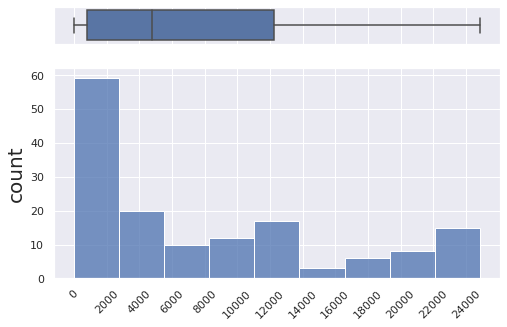

In [74]:
# create histo boxplot
digits = len(str(max(all_num_loci_counts['num_loci']))) - 2 
xtick = round(max(all_num_loci_counts['num_loci'])/13, -digits)
if xtick < 10:
    xtick = 10
    
histo_box(all_num_loci_counts['num_loci'].tolist(), xticks_by=xtick, rotation=45)

In [75]:
# save
all_num_file = op.join(ronadir, 'all_num_loci_counts.txt')
all_num_loci_counts.to_csv(all_num_file, sep='\t', index=False)

In [76]:
# time to finish notebook
formatclock(dt.now() - t1, exact=True)

'0-00:36:25'